In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

np.random.seed(0)

In [ ]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
from numpy.random import randn
def generate_latent_points(latent_dim, n_samples):
    z = Variable(torch.Tensor(np.random.normal(0, 1, (n_samples, latent_dim))))
    return z

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def show(imgs):
    tmp = (imgs + 1)/2
    grid = vutils.make_grid(tmp.cpu())
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [ ]:
img_shape = (1, 28, 28)

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


In [ ]:
class CGenerator(nn.Module):
    def __init__(self):
        super(CGenerator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100 + 10, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod((1, 28, 28)))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *(1, 28, 28))
        return img

In [ ]:
netG = Generator()
netCG = CGenerator()

In [ ]:
netG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-generator.pth', map_location=torch.device('cpu')))
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
netG.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
netCG.eval()

CGenerator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
from numpy import linspace
from numpy import asarray

def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

In [ ]:
latent_points = generate_latent_points(100, 25)

In [ ]:
latent_points.shape

torch.Size([25, 100])

In [ ]:
generated = netG(latent_points)

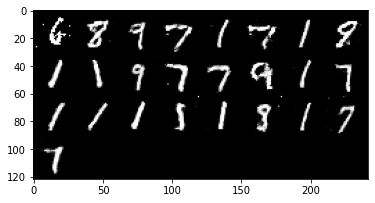

In [ ]:
show(generated)

In [ ]:
one = netG(latent_points[:1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


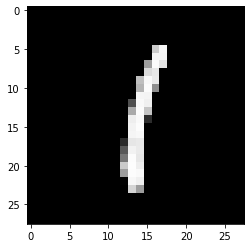

In [ ]:
show(one)

In [ ]:
seven = netG(latent_points[8].unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


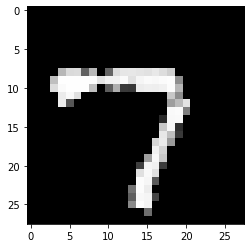

In [ ]:
show(seven)

In [ ]:
interpolated = interpolate_points(latent_points[0].numpy(), latent_points[8].numpy())

In [ ]:
interpolated = torch.Tensor(interpolated)

In [ ]:
X = netG(interpolated)

In [ ]:
X = (X + 1) / 2.0

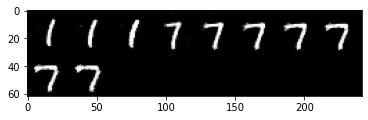

In [ ]:
show(X)

# CGAN

In [ ]:
ones = torch.full((25,), 1)

In [ ]:
generated_ones = netCG(latent_points, ones)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


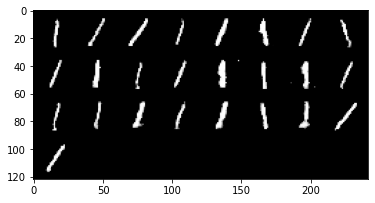

In [ ]:
show(generated_ones)

In [ ]:
sevens = torch.full((25,), 7)

In [ ]:
generated_sevens = netCG(latent_points, sevens)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


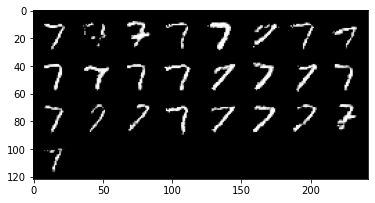

In [ ]:
show(generated_sevens)

In [ ]:
embedding_weights = netCG.label_emb.weight

## Set embedding weights to 0


In [ ]:
netCG.label_emb.weight

Parameter containing:
tensor([[-0.7859, -0.2367,  3.2536,  0.7618, -0.7222, -0.6586,  0.7585, -1.2526,
          0.7239, -1.2258],
        [ 1.3597, -0.8621, -1.1897,  0.8339,  1.0711, -1.4130,  1.0173,  2.3083,
         -1.6028, -1.6679],
        [-0.2900,  2.7176, -1.3967, -0.4227, -0.5758, -0.9118,  1.2356,  0.1804,
          0.3592, -1.0345],
        [-0.3973,  2.4682,  0.6627,  0.9941, -0.7341,  1.3136, -0.0643,  0.3206,
          0.2635,  1.8582],
        [ 0.6953, -0.4136,  2.6467,  0.0441,  1.5518, -1.8377, -0.6749,  2.3572,
         -0.1954,  1.8579],
        [ 0.3306, -1.3099,  0.7520, -1.0817, -0.4827, -2.2320, -0.4284, -1.2132,
          0.3028, -0.6169],
        [ 1.8082, -0.7534, -0.2684,  0.1973, -0.7918,  1.2687,  1.0792,  1.1657,
          1.0411, -0.2534],
        [-1.3612, -0.9088,  0.7602, -0.1098,  2.4046,  0.6707, -1.4818, -1.7961,
          0.3041,  1.0504],
        [ 0.2707,  0.9881, -0.4581,  1.0705,  1.1374,  2.8613, -2.2355, -1.5454,
         -1.7782, -0.7780

In [ ]:
netCG.label_emb.weight = torch.nn.Parameter(torch.full((10, 10), 0.))

In [ ]:
netCG.label_emb.weight

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

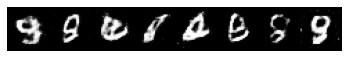

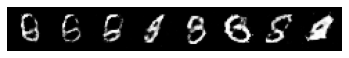

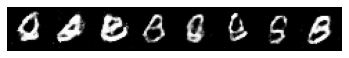

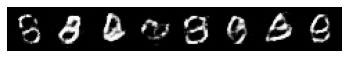

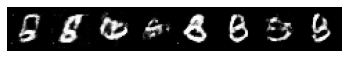

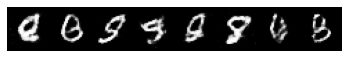

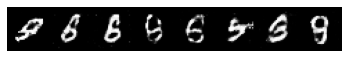

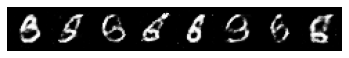

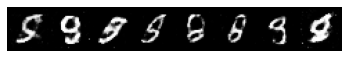

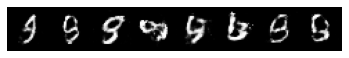

In [ ]:
for i in range(10):
    current = torch.full((8, ), i)
    latent_points = generate_latent_points(100, 8)
    generated = netCG(latent_points, current)
    show(generated)

## interpolate with embeddings

In [ ]:
latent_points = generate_latent_points(100, 8)

In [ ]:
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
embedding_weights = netCG.label_emb.weight.detach().cpu()

In [ ]:
inbetween = interpolate_points(embedding_weights[3], embedding_weights[8])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


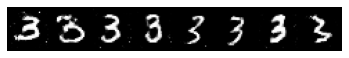

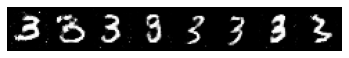

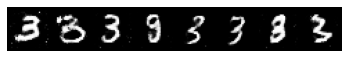

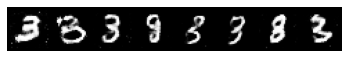

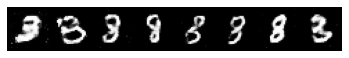

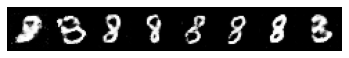

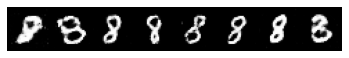

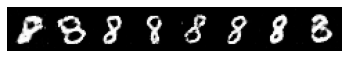

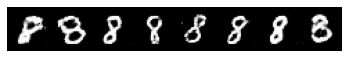

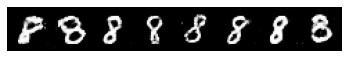

In [ ]:
threes = torch.full((8,), 3)
for i in range(10):
    with torch.no_grad():
        netCG.label_emb.weight[3] = inbetween[i]
        generated = netCG(latent_points, threes)
        show(generated)

## Vector arithmetics

In [ ]:
latent_points = generate_latent_points(100, 8)

In [ ]:
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
embedding_weights = netCG.label_emb.weight

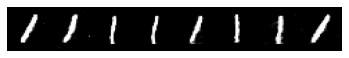

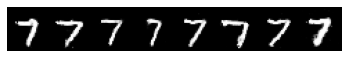

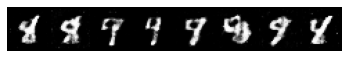

In [ ]:
ones = torch.full((8,), 1)
sevens = torch.full((8,), 7)
with torch.no_grad():
    generated = netCG(latent_points, ones)
    show(generated)
    generated = netCG(latent_points, sevens)
    show(generated)
    netCG.label_emb.weight[1] = netCG.label_emb.weight[1] + netCG.label_emb.weight[7]
    generated = netCG(latent_points, ones)
    show(generated)

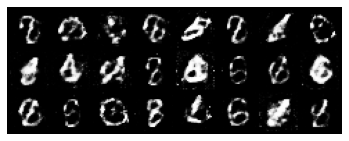

In [ ]:
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))
threes = torch.full((24,), 3)
with torch.no_grad():
    netCG.label_emb.weight[3] = netCG.label_emb.weight[1] + netCG.label_emb.weight[0]
    generated = netCG(latent_points, threes)
    show(generated)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


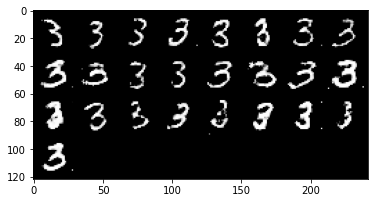

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


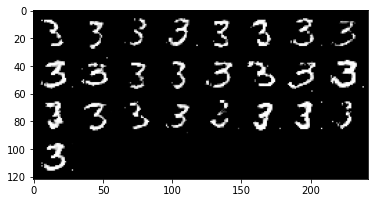

In [ ]:
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))
threes = torch.full((25,), 3)
with torch.no_grad():
    generated = netCG(latent_points, threes)
    show(generated)
    netCG.label_emb.weight[3] = netCG.label_emb.weight[3] * 1.5
    generated = netCG(latent_points, threes)
    show(generated)

## Test setting embedding weights column to 0

In [ ]:
latent_points = generate_latent_points(100, 25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


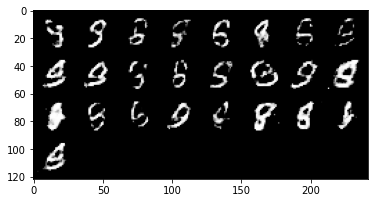

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


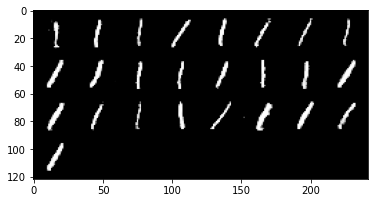

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


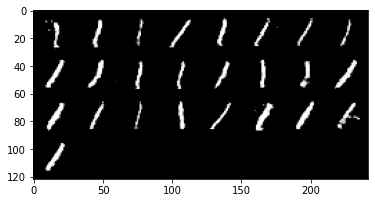

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


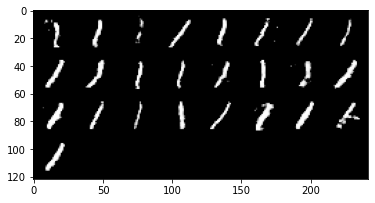

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


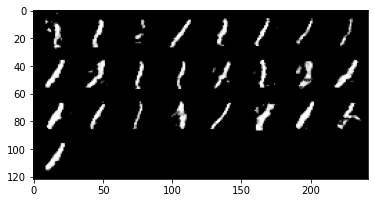

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


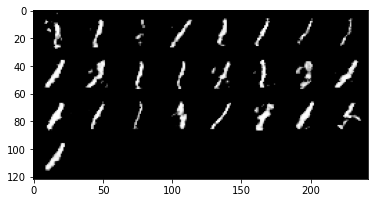

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


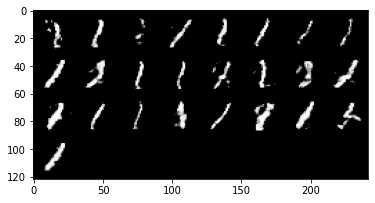

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


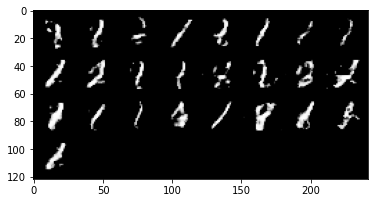

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


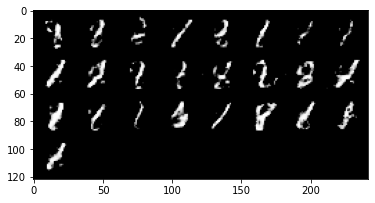

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


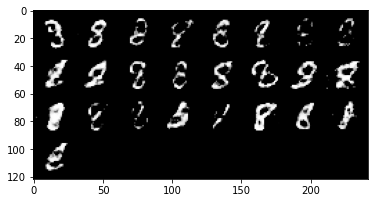

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


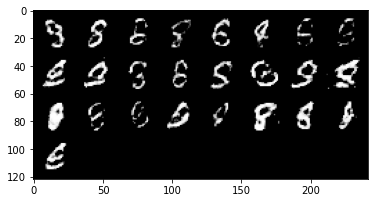

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


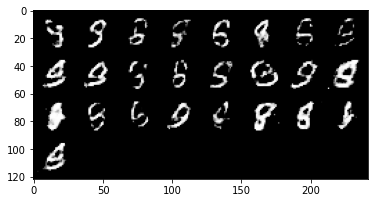

In [ ]:

ones = torch.full((25,), 1)
netCG.label_emb.weight = torch.nn.Parameter(torch.full((10, 10), 0.))
generated = netCG(latent_points, ones)
show(generated)
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))
starting_embedding = netCG.label_emb.weight
generated = netCG(latent_points, ones)
show(generated)
for i in range(10):
    with torch.no_grad():
        netCG.label_emb.weight[1] = starting_embedding[1]
        netCG.label_emb.weight[1][i] = 0.
        generated = netCG(latent_points, ones)
        show(generated)

In [ ]:
from skimage.metrics import mean_squared_error as mse
# transforms.ToPILImage()(img_data)

for i in range(10):
    zeroes = torch.full((25,), i)
    starting_embedding = netCG.label_emb.weight
    original = netCG(latent_points, zeroes)
    original = original.detach().numpy()
    largest_mse = 0
    largest_idx = 0
    total_mse = 0
    for j in range(10):
        netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))
        with torch.no_grad():
            netCG.label_emb.weight[i] = starting_embedding[i]
            netCG.label_emb.weight[i][j] = 0.
            generated = netCG(latent_points, zeroes)
            generated = generated.detach().numpy()
            curr_mse = 0
            for idx, img in enumerate(generated):
                curr_mse += mse(original[idx], img)
        if curr_mse > largest_mse:
            largest_mse = curr_mse
            largest_idx = j
    print(largest_mse)
    print(largest_idx)

4.663324340154243
2
0.932182079429501
9
4.713023858856771
1
2.7733580421424158
1
1.6048685778033913
2
2.166806711163649
5
1.4544741244566988
0
3.5953422024324393
4
1.951635257168336
5
2.705528001556446
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


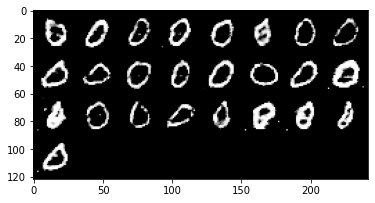

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0458586869769346


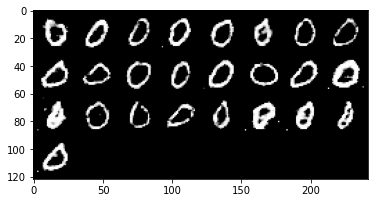

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4279609413888562


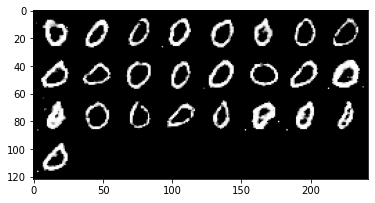

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.1043666993864007


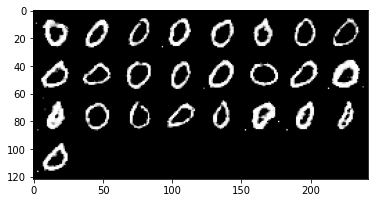

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0


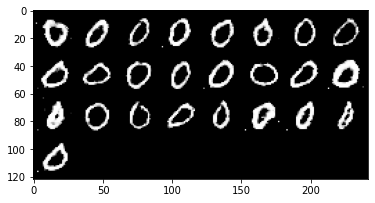

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0884601792778349


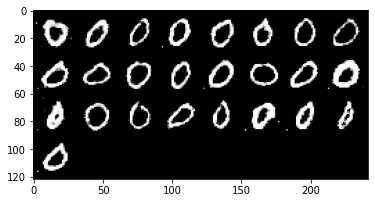

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.3088306461301652


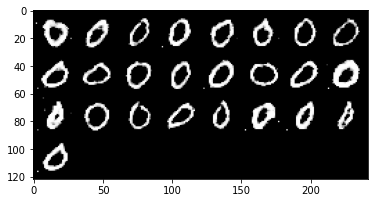

0.6011703711893637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


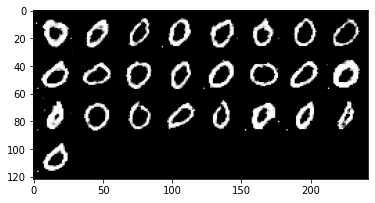

0.9354622216084812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


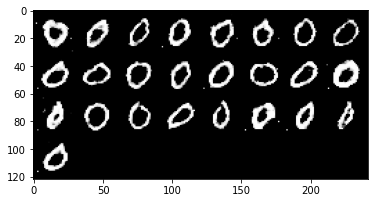

1.324799226900977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


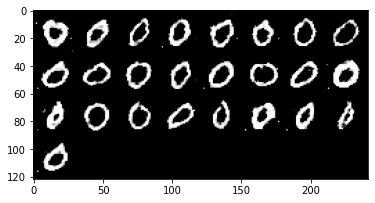

1.7675122157802272


In [ ]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim

zeroes = torch.full((25,), 0)
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))
original = netCG(latent_points, zeroes)
original = original.detach().numpy()
with torch.no_grad():
    netCG.label_emb.weight[0] = starting_embedding[0]
    inbetween = interpolate_points(netCG.label_emb.weight[0][2]*0.5, netCG.label_emb.weight[0][2]*2)
    for i in range(10):
        curr_mse = 0
        tmp = netCG.label_emb.weight[0].detach().numpy()
        tmp[2] = inbetween[i]
        netCG.label_emb.weight[0] = torch.from_numpy(tmp)
        generated = netCG(latent_points, zeroes)
        show(generated)
        generated = generated.detach().numpy()
        for idx, img in enumerate(generated):
            curr_mse += mse(original[idx], img)
        print(curr_mse)

In [ ]:
from skimage.metrics import mean_squared_error as mse

zeroes = torch.full((25,), 0)
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))
original = netCG(latent_points, zeroes)
original = original.detach().numpy()
with torch.no_grad():
    netCG.label_emb.weight[0] = starting_embedding[0]
    inbetween = interpolate_points(netCG.label_emb.weight[0][2], netCG.label_emb.weight[0][2]*2)
    for i in range(10):
        curr_mse = 0
        tmp = netCG.label_emb.weight[0].detach().numpy()
        tmp[2] = inbetween[i]
        netCG.label_emb.weight[0] = torch.from_numpy(tmp)
        generated = netCG(latent_points, zeroes)
        generated = generated.detach().numpy()
        for idx, img in enumerate(generated):
            curr_mse += mse(original[idx], img)
        print(curr_mse)

## Adding noise to generator embedding



In [ ]:
class GaussianNoise(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, std=0.05, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [ ]:
class CGeneratorN(nn.Module):
    def __init__(self):
        super(CGeneratorN, self).__init__()

        self.label_emb = nn.Embedding(10, 10)
        self.gaussian_noise = GaussianNoise()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100 + 10, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod((1, 28, 28)))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        label_input = self.gaussian_noise(self.label_emb(labels))
        gen_input = torch.cat((label_input, noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *(1, 28, 28))
        return img

In [ ]:
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
netCGN = CGeneratorN()

In [ ]:
netCGN.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


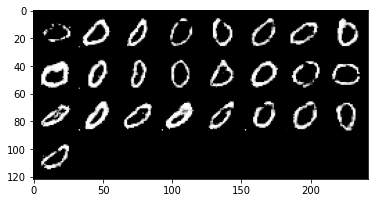

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


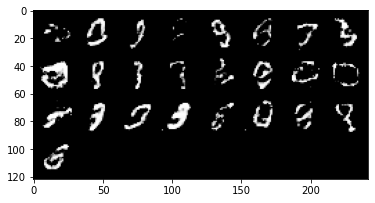

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


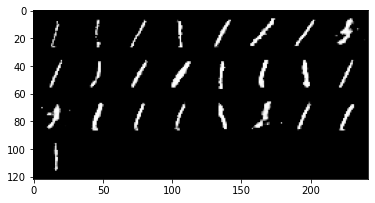

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


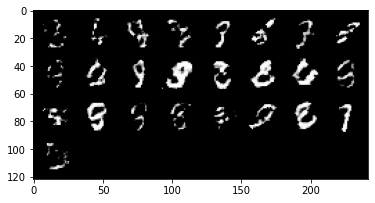

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


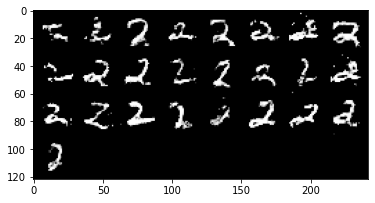

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


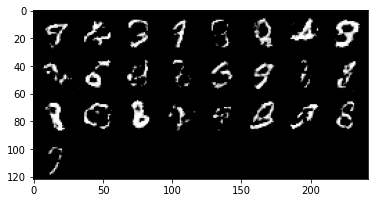

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


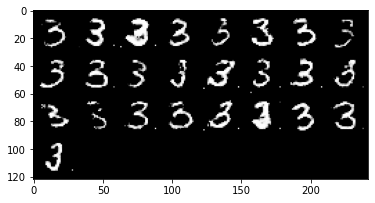

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


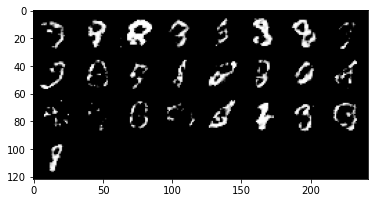

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


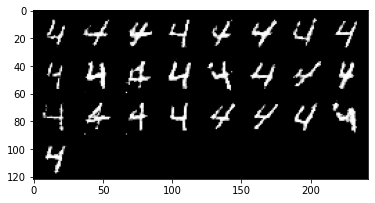

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


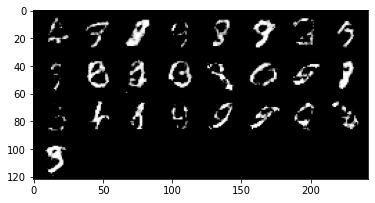

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


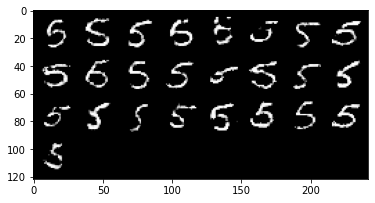

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


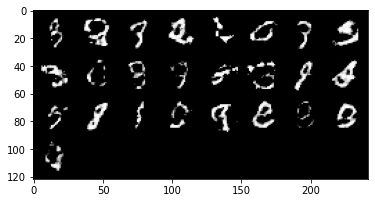

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


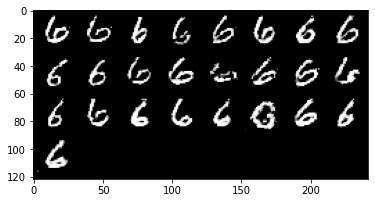

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


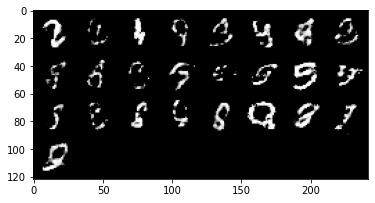

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


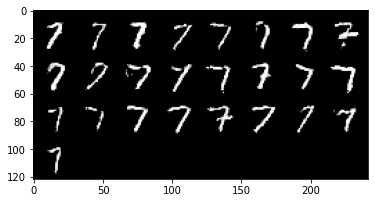

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


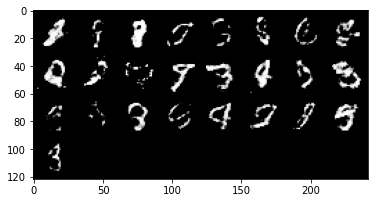

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8


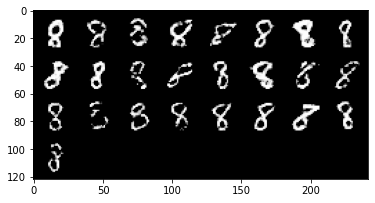

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


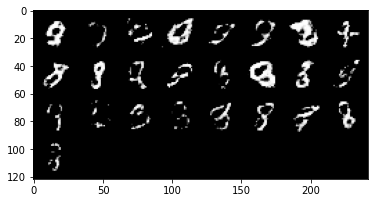

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


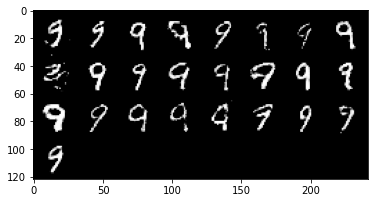

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


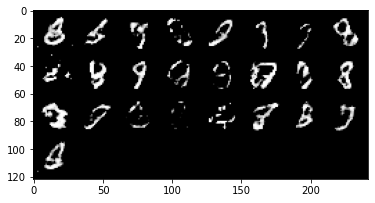

In [ ]:
for i in range(10):
    print(i)
    current = torch.full((25, ), i)
    latent_points = generate_latent_points(100, 25)
    generated = netCG(latent_points, current)
    show(generated)
    generated = netCGN(latent_points, current)
    show(generated)

## Visualization

In [ ]:
embedding_weights = netCG.label_emb.weight.detach().numpy()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3)

pca_result = pca.fit_transform(embedding_weights)

In [ ]:
pca.explained_variance_ratio_

array([0.28097862, 0.21572606, 0.15488172], dtype=float32)

In [ ]:
import seaborn as sns

In [ ]:
import pandas as pd

feat_cols = [ 'feature'+str(i) for i in range(embedding_weights.shape[1]) ]
df = pd.DataFrame(embedding_weights,columns=feat_cols)

In [ ]:
y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

In [ ]:
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

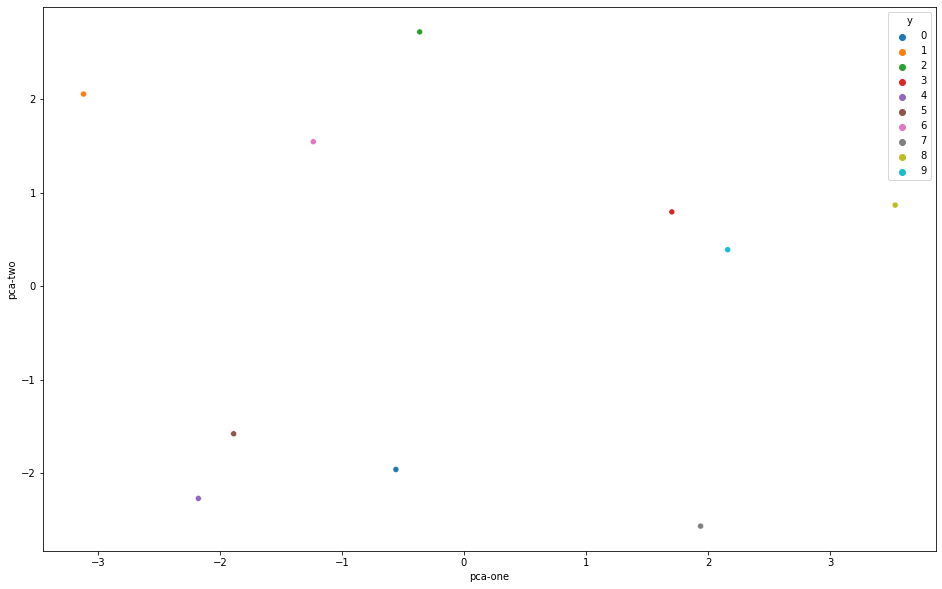

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=df.loc[:,:],
    legend="full",
    alpha=1
)

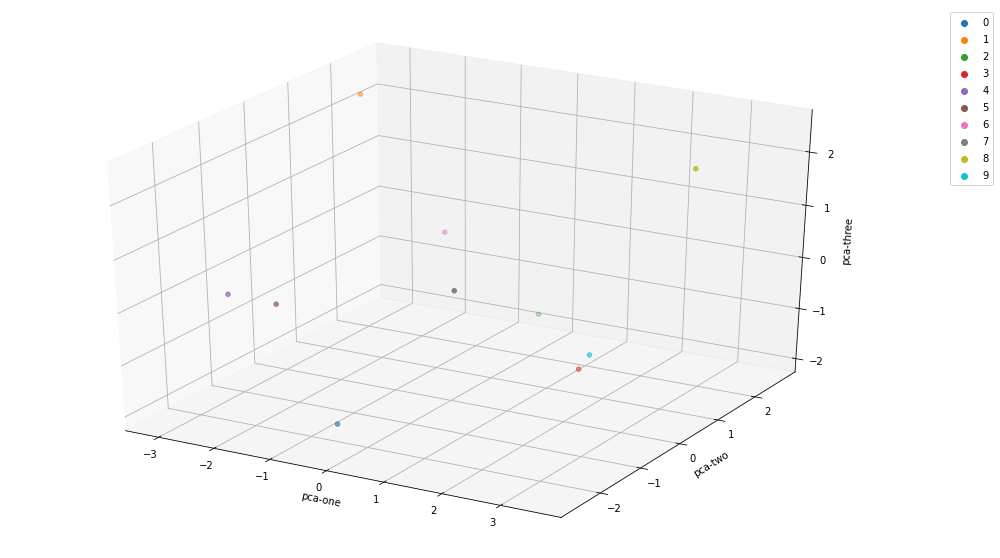

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
sc = ax.scatter(
    xs=df.loc[:,:]["pca-one"], 
    ys=df.loc[:,:]["pca-two"], 
    zs=df.loc[:,:]["pca-three"],
    c=df.loc[:,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

In [ ]:
latent_points = generate_latent_points(100, 25)

## Riemannian metric walk

In [ ]:
!pip install geomstats

     |████████████████████████████████| 9.5 MB 5.2 MB/s 
     |████████████████████████████████| 294 kB 46.3 MB/s 
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1


In [ ]:
embedding_weights = netCG.label_emb.weight.detach().numpy()

In [ ]:
embedding_weights

array([[-2.6858873 ,  0.06331189,  1.953555  ,  1.8617715 , -2.0222204 ,
        -2.1585717 ,  0.85848176, -0.7526134 ,  2.2239187 , -1.3257667 ],
       [ 1.3596896 , -0.86212933, -1.1896766 ,  0.833946  ,  1.071069  ,
        -1.4129599 ,  1.0172771 ,  2.3083107 , -1.6027962 , -1.6679367 ],
       [-0.29001147,  2.7175837 , -1.396723  , -0.42267108, -0.57580227,
        -0.9118071 ,  1.2356395 ,  0.18036851,  0.35924983, -1.0344825 ],
       [-0.39730254,  2.4681664 ,  0.66273385,  0.9941393 , -0.73411876,
         1.3136485 , -0.06430471,  0.32056838,  0.26353064,  1.8581877 ],
       [ 0.6952837 , -0.41359848,  2.6466534 ,  0.04408066,  1.5518246 ,
        -1.8377287 , -0.67487913,  2.3571768 , -0.19540349,  1.8578966 ],
       [ 0.33055288, -1.3098722 ,  0.75200737, -1.0817212 , -0.48273546,
        -2.2319906 , -0.4283578 , -1.2132316 ,  0.3027861 , -0.61693084],
       [ 1.8081616 , -0.7534152 , -0.2683723 ,  0.1972971 , -0.7917723 ,
         1.2686597 ,  1.0792083 ,  1.1657451 

In [ ]:
import numpy as np
import geomstats.backend as gs
from geomstats.geometry.hypersphere import Hypersphere

class BrownianWithRiemannian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        
        self.x0 = x0
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        sphere = Hypersphere(dim=9)
        curr_point = self.x0

        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.full((n_step, 10), self.x0)

        print(w.shape)
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1], (10,))

            random_tangent_vec = sphere.to_tangent(
                yi, 
                base_point=curr_point)
            curr_point = sphere.metric.exp(random_tangent_vec, base_point=curr_point)

            w[i] = curr_point
            # # Weiner process
            # w[i] = w[i-1]+(curr_point/np.sqrt(n_step))
        
        return w

In [ ]:
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))
brownian_r = BrownianWithRiemannian(netCG.label_emb.weight[1].detach().numpy())

In [ ]:
walk_r = brownian_r.gen_random_walk()

(100, 10)


tensor([ 1.3597, -0.8621, -1.1897,  0.8339,  1.0711, -1.4130,  1.0173,  2.3083,
        -1.6028, -1.6679], requires_grad=True)


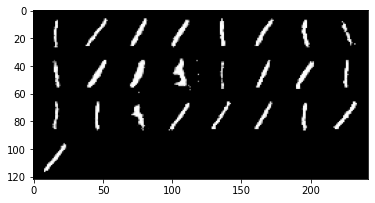

tensor([-1.2299,  0.7395,  1.0623, -0.9323, -0.9454,  1.2824, -1.1130, -2.1649,
         1.4695,  1.7544], requires_grad=True)


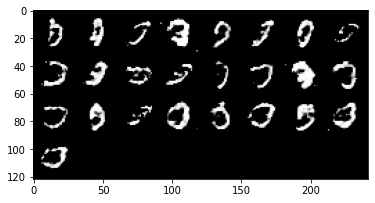

tensor([ 1.2252, -0.7443, -1.0672,  0.9276,  0.9407, -1.2873,  1.1179,  2.1603,
        -1.4649, -1.7593], requires_grad=True)


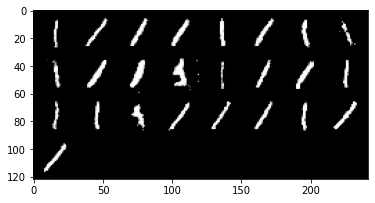

tensor([-1.2245,  0.7452,  1.0665, -0.9285, -0.9400,  1.2882, -1.1188, -2.1597,
         1.4658,  1.7586], requires_grad=True)


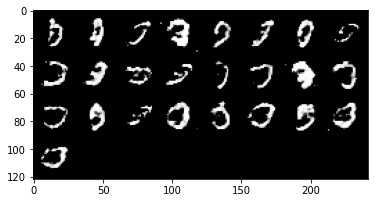

tensor([ 1.2269, -0.7477, -1.0689,  0.9254,  0.9425, -1.2850,  1.1212,  2.1618,
        -1.4625, -1.7553], requires_grad=True)


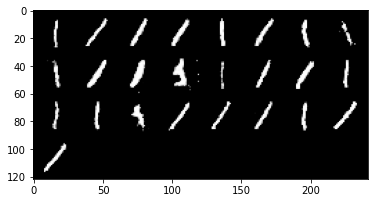

tensor([-1.2264,  0.7482,  1.0694, -0.9258, -0.9419,  1.2845, -1.1217, -2.1612,
         1.4629,  1.7557], requires_grad=True)


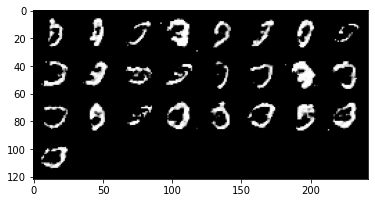

tensor([ 1.2324, -0.7543, -1.0627,  0.9192,  0.9353, -1.2904,  1.1150,  2.1542,
        -1.4689, -1.7615], requires_grad=True)


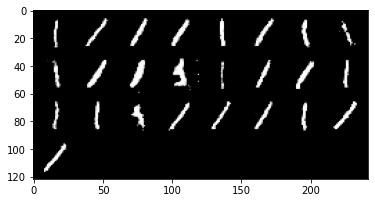

tensor([-0.8057,  0.3856,  0.6566, -1.0850, -0.5447,  0.8568, -1.2571, -1.6159,
         1.0136,  1.2708], requires_grad=True)


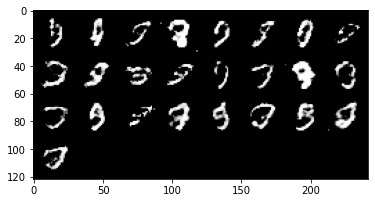

tensor([ 0.8017, -0.3899, -0.6610,  1.0894,  0.5406, -0.8528,  1.2615,  1.6120,
        -1.0180, -1.2668], requires_grad=True)


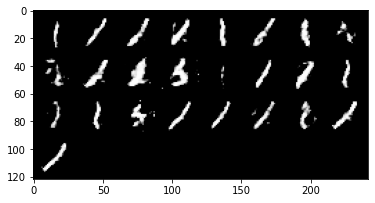

tensor([-0.7952,  0.3838,  0.6546, -1.0827, -0.5457,  0.8575, -1.2659, -1.6160,
         1.0113,  1.2712], requires_grad=True)


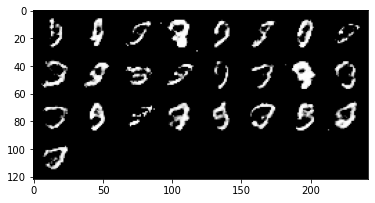

tensor([ 0.8288, -0.4477, -0.6986,  1.0951,  0.5977, -0.8865,  1.2648,  1.4048,
        -0.8446, -1.2697], requires_grad=True)


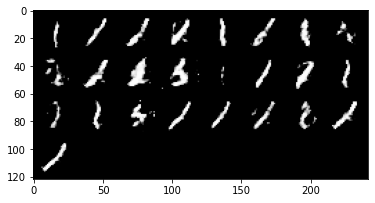

tensor([-0.6087,  0.2727,  0.7380, -0.8435, -0.6491,  0.9037, -1.2373, -1.3608,
         0.8668,  1.2416], requires_grad=True)


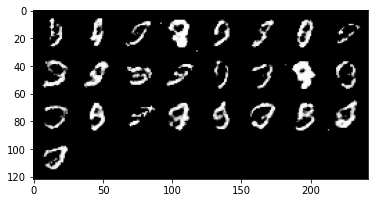

tensor([ 0.6116, -0.2757, -0.7409,  0.8401,  0.6519, -0.9004,  1.2400,  1.3572,
        -0.8634, -1.2443], requires_grad=True)


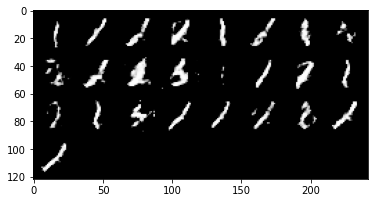

tensor([-0.1288,  0.4203,  0.7081, -0.7695, -0.6531,  0.8068, -1.0169, -1.0895,
         0.2846,  1.0196], requires_grad=True)


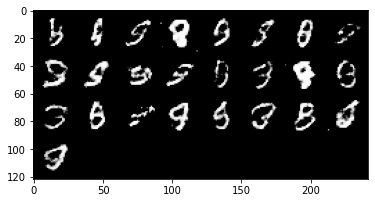

tensor([ 0.1300, -0.4192, -0.7094,  0.7709,  0.6520, -0.8058,  1.0159,  1.0909,
        -0.2859, -1.0186], requires_grad=True)


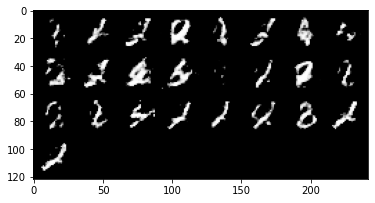

tensor([-0.0898,  0.4641,  0.6742, -0.7361, -0.6163,  0.8541, -0.9834, -1.1416,
         0.2470,  0.9861], requires_grad=True)


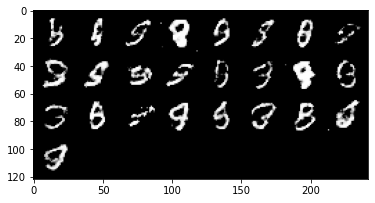

tensor([-0.2937, -0.0561, -1.0076,  0.3103,  0.1983, -0.4205,  0.5413,  0.6892,
         0.1468, -0.5438], requires_grad=True)


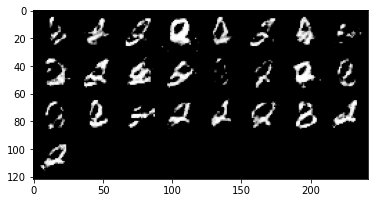

tensor([ 0.3378, -0.0092,  1.0084, -0.3533, -0.1244,  0.3331, -0.5703, -0.7093,
        -0.1998,  0.4490], requires_grad=True)


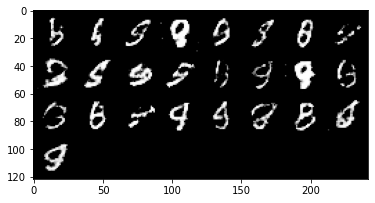

tensor([-0.2955, -0.0401, -0.9803,  0.4103,  0.1765, -0.2907,  0.6319,  0.6748,
         0.2535, -0.4090], requires_grad=True)


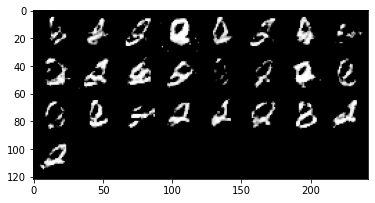

tensor([ 0.2864,  0.0503,  0.9734, -0.4016, -0.1671,  0.3017, -0.6440, -0.6870,
        -0.2443,  0.4003], requires_grad=True)


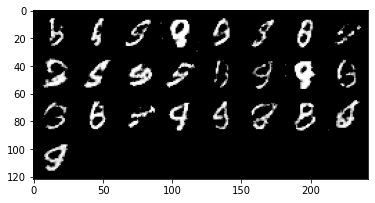

tensor([-0.0922, -0.2761, -0.8436,  0.2182,  0.4038, -0.1089,  0.4833,  0.5304,
         0.0462, -0.6589], requires_grad=True)


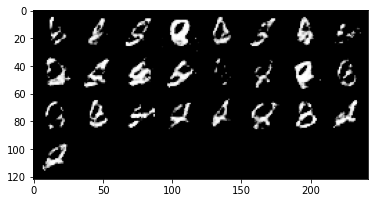

tensor([ 0.0805,  0.2653,  0.8354, -0.2312, -0.3936,  0.0974, -0.4734, -0.5448,
        -0.0343,  0.6739], requires_grad=True)


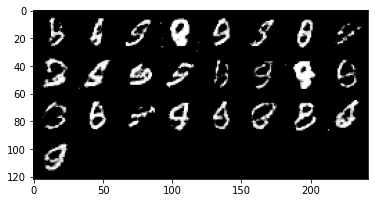

tensor([-0.0559, -0.2938, -0.8192,  0.2082,  0.4235, -0.1240,  0.5043,  0.5254,
         0.0603, -0.6559], requires_grad=True)


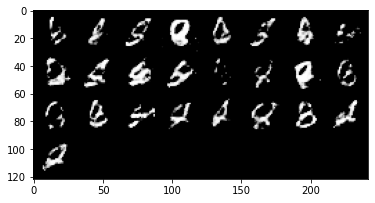

tensor([ 0.0563,  0.2942,  0.8187, -0.2078, -0.4231,  0.1236, -0.5047, -0.5257,
        -0.0607,  0.6562], requires_grad=True)


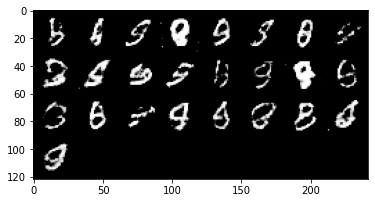

tensor([-0.2564, -0.3774, -0.6443,  0.3335,  0.4430, -0.2907,  0.0290,  0.4952,
         0.2586, -0.5616], requires_grad=True)


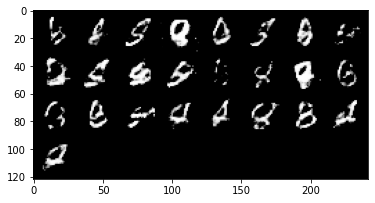

tensor([ 0.2879,  0.4043,  0.5781, -0.2793, -0.4673,  0.3208, -0.0692, -0.5175,
        -0.2073,  0.5814], requires_grad=True)


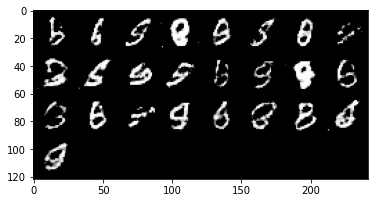

tensor([-0.3045, -0.4193, -0.5497,  0.2550,  0.4404, -0.3370,  0.0477,  0.5310,
         0.2250, -0.5940], requires_grad=True)


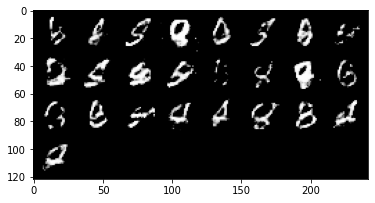

tensor([ 0.3352,  0.3982,  0.5837, -0.2317, -0.4729,  0.3149, -0.0750, -0.5114,
        -0.2014,  0.5753], requires_grad=True)


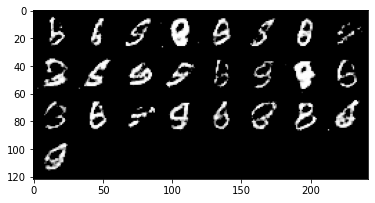

tensor([-0.3311, -0.3942, -0.5893,  0.2274,  0.4690, -0.3201,  0.0798,  0.5076,
         0.1970, -0.5809], requires_grad=True)


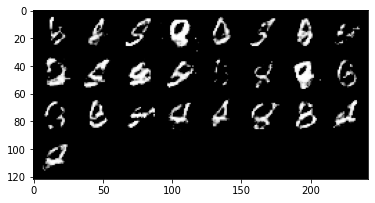

tensor([-0.3703,  0.3468,  0.3405, -0.3522, -0.3444,  0.3492,  0.3622, -0.3432,
        -0.3532,  0.3408], requires_grad=True)


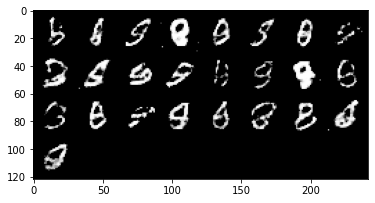

tensor([ 0.3768, -0.3533, -0.3470,  0.3587,  0.3378, -0.3426, -0.3556,  0.3366,
         0.3466, -0.3473], requires_grad=True)


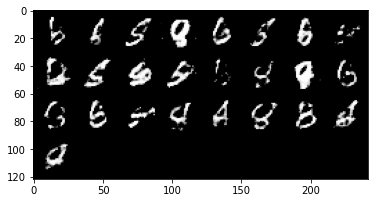

tensor([-0.3887,  0.3336,  0.3274, -0.3708, -0.3183,  0.3549,  0.3677, -0.3489,
        -0.3270,  0.3595], requires_grad=True)


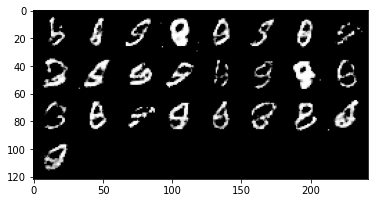

tensor([ 0.4768, -0.2826, -0.2760,  0.3217,  0.2665, -0.4413, -0.3184,  0.2987,
         0.2756, -0.4461], requires_grad=True)


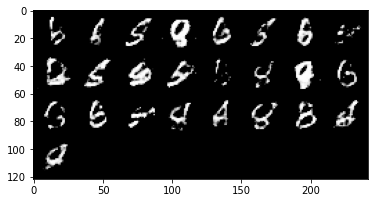

tensor([-0.1213,  0.0012,  0.3442, -0.3725, -0.3383,  0.4464,  0.3705, -0.3582,
        -0.3440,  0.4494], requires_grad=True)


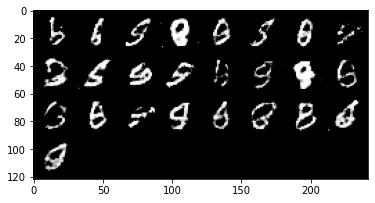

tensor([ 0.1308, -0.0102, -0.3546,  0.3651,  0.3308, -0.4394, -0.3631,  0.3687,
         0.3365, -0.4602], requires_grad=True)


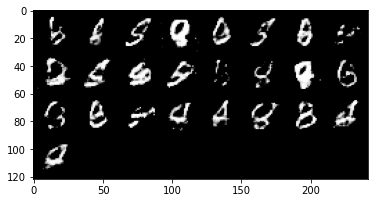

tensor([-0.2039,  0.0771,  0.4393, -0.3174, -0.2814,  0.3955,  0.3153, -0.3212,
        -0.2874,  0.5503], requires_grad=True)


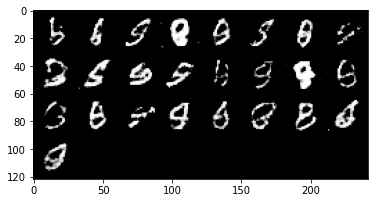

tensor([ 0.2272, -0.1036, -0.4566,  0.3378,  0.2458, -0.4139, -0.3358,  0.2846,
         0.3085, -0.5080], requires_grad=True)


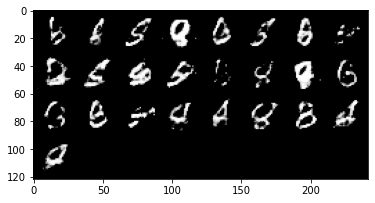

tensor([-0.3569,  0.0049,  0.3910, -0.4779, -0.1604,  0.3443,  0.2588, -0.4196,
        -0.2290,  0.4471], requires_grad=True)


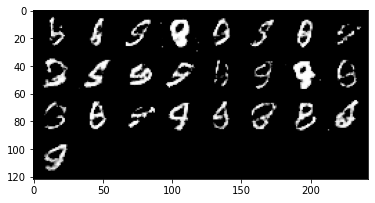

tensor([ 0.6155, -0.1988, -0.2701,  0.3730, -0.0029, -0.2148, -0.1135,  0.3040,
         0.4641, -0.3365], requires_grad=True)


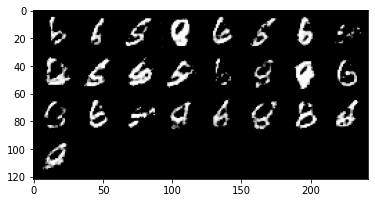

tensor([-0.6105,  0.1923,  0.2639, -0.3812, -0.0041,  0.2084,  0.1068, -0.2979,
        -0.4727,  0.3447], requires_grad=True)


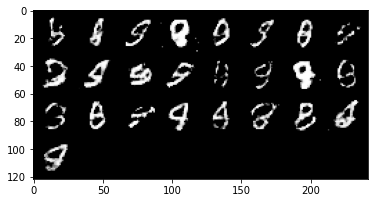

tensor([ 0.5596, -0.3251, -0.1777,  0.5332,  0.1176, -0.1166, -0.2308,  0.2152,
         0.4078, -0.2668], requires_grad=True)


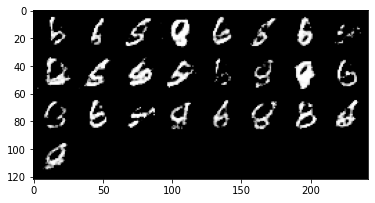

tensor([-0.5529,  0.3359,  0.1692, -0.5263, -0.1275,  0.1264,  0.2226, -0.2256,
        -0.4190,  0.2586], requires_grad=True)


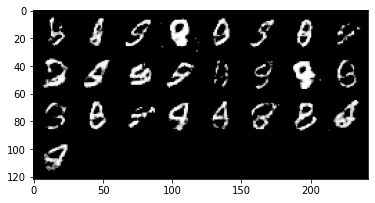

tensor([ 0.5185, -0.2911, -0.1163,  0.4907,  0.1947, -0.1936, -0.1723,  0.2975,
         0.5003, -0.2101], requires_grad=True)


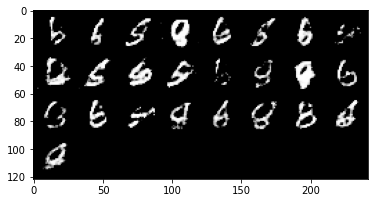

tensor([-0.5168,  0.3463,  0.2154, -0.4959, -0.2741,  0.0168,  0.2573, -0.0947,
        -0.5031,  0.0292], requires_grad=True)


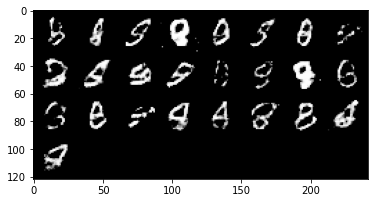

tensor([ 0.4069, -0.6636, -0.0331,  0.3811,  0.1060,  0.2132, -0.0851, -0.1166,
         0.3900, -0.2702], requires_grad=True)


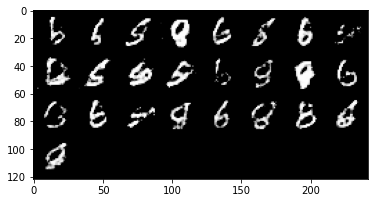

tensor([-0.4005,  0.6693,  0.0393, -0.3870, -0.0997, -0.2192,  0.0913,  0.1103,
        -0.3835,  0.2638], requires_grad=True)


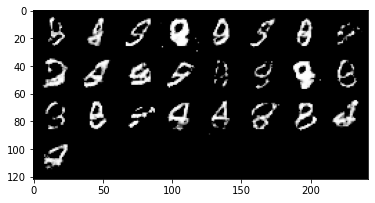

tensor([ 0.4068, -0.6625, -0.0328,  0.3804,  0.1062,  0.2126, -0.0977, -0.1167,
         0.3898, -0.2702], requires_grad=True)


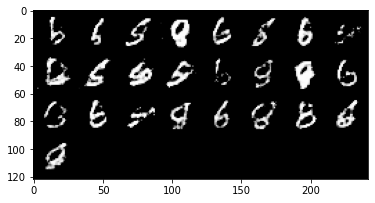

tensor([-0.4250,  0.6532,  0.0182, -0.3687, -0.0922, -0.2292,  0.0837,  0.1325,
        -0.3782,  0.2873], requires_grad=True)


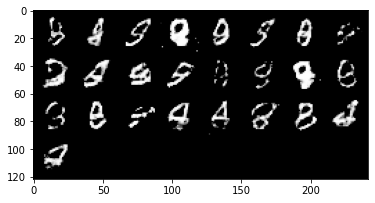

tensor([ 0.4287, -0.6509, -0.0214,  0.3660,  0.0892,  0.2263, -0.0806, -0.1295,
         0.3819, -0.2908], requires_grad=True)


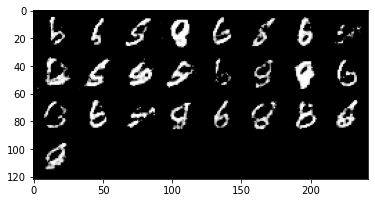

tensor([-0.4314,  0.6488,  0.0239, -0.3638, -0.0917, -0.2289,  0.0782,  0.1321,
        -0.3797,  0.2935], requires_grad=True)


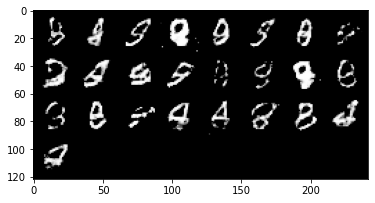

tensor([ 0.4406, -0.6306, -0.0364,  0.3735,  0.1037,  0.2398, -0.0648, -0.1437,
         0.3892, -0.2783], requires_grad=True)


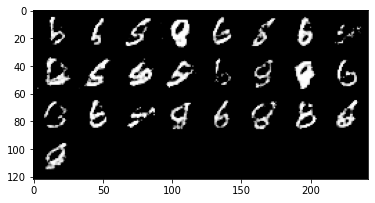

tensor([-0.4212,  0.5165,  0.2188, -0.3876, -0.2524, -0.3206,  0.2330, -0.1285,
        -0.3955, -0.0611], requires_grad=True)


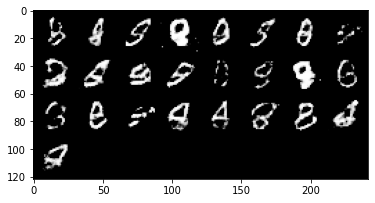

tensor([ 0.0323,  0.0865, -0.2848,  0.0742,  0.2428,  0.1577, -0.2671, -0.7178,
         0.0643,  0.4814], requires_grad=True)


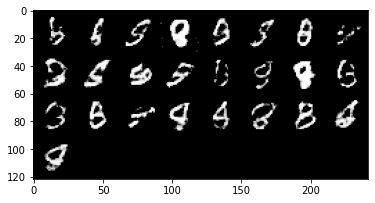

tensor([ 0.1932, -0.3426,  0.1243,  0.1405, -0.0715, -0.4321,  0.1020,  0.6688,
         0.1529, -0.3716], requires_grad=True)


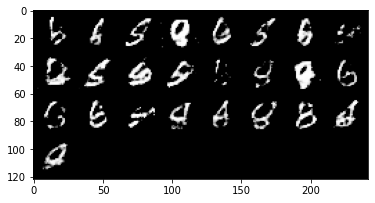

tensor([-0.1943,  0.3437, -0.1254, -0.1395,  0.0705,  0.4313, -0.1031, -0.6680,
        -0.1520,  0.3727], requires_grad=True)


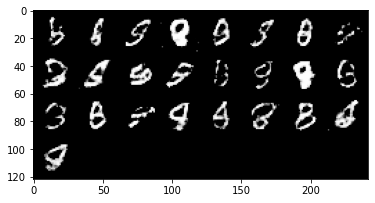

tensor([ 0.1881, -0.3501,  0.1316,  0.1458, -0.0768, -0.4376,  0.0968,  0.6620,
         0.1583, -0.3666], requires_grad=True)


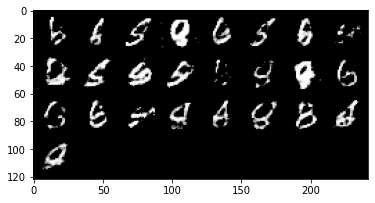

tensor([-0.1614,  0.3885, -0.1037, -0.1182,  0.0476,  0.4779, -0.1298, -0.6454,
        -0.1308,  0.3437], requires_grad=True)


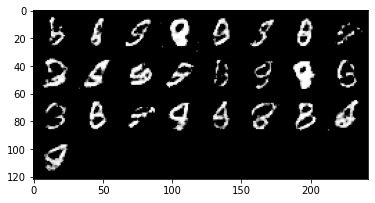

tensor([ 0.1548, -0.3818,  0.0971,  0.1246, -0.0541, -0.4712,  0.1232,  0.6517,
         0.1373, -0.3500], requires_grad=True)


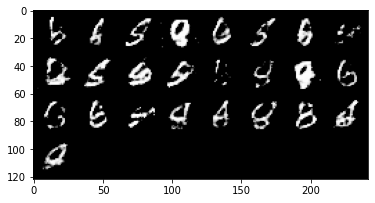

tensor([-0.1594,  0.3862, -0.0922, -0.1293,  0.0588,  0.4660, -0.1183, -0.6558,
        -0.1324,  0.3449], requires_grad=True)


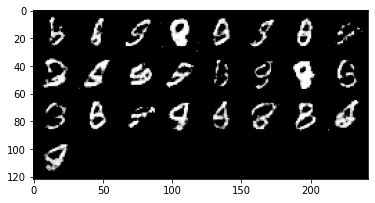

tensor([ 0.1633, -0.3812,  0.0963,  0.1333, -0.0545, -0.4692,  0.1138,  0.6587,
         0.1279, -0.3400], requires_grad=True)


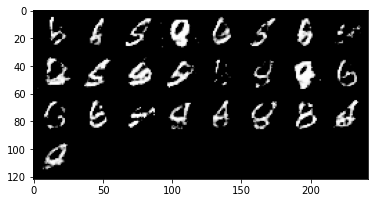

tensor([-0.2326,  0.4616, -0.0403, -0.0792,  0.1182,  0.4324, -0.1806, -0.6316,
        -0.0735,  0.2965], requires_grad=True)


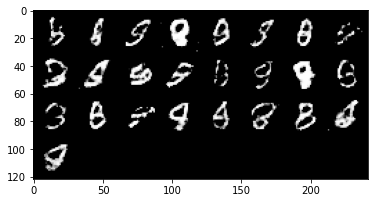

tensor([ 0.1800, -0.5534,  0.1083,  0.1493, -0.1905, -0.3911,  0.1251,  0.6015,
         0.0120, -0.2476], requires_grad=True)


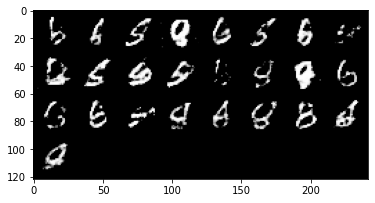

tensor([-0.1140,  0.5138, -0.1947, -0.2387,  0.1253,  0.4975, -0.0552, -0.5653,
        -0.0916,  0.1863], requires_grad=True)


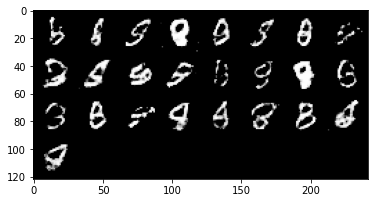

tensor([ 0.1065, -0.5078,  0.1875,  0.2316, -0.1337, -0.4915,  0.0634,  0.5756,
         0.0999, -0.1950], requires_grad=True)


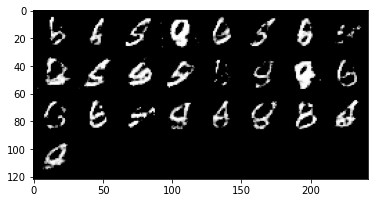

tensor([-0.2163,  0.2119, -0.2728, -0.3036,  0.2353,  0.4847, -0.1863, -0.5433,
        -0.2118,  0.2781], requires_grad=True)


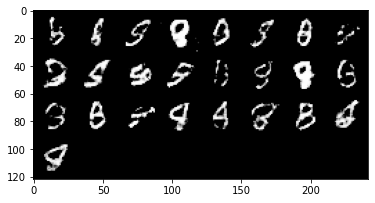

tensor([ 0.0428, -0.0395,  0.3291,  0.1091, -0.3006, -0.4903,  0.2633,  0.5348,
         0.2827, -0.3331], requires_grad=True)


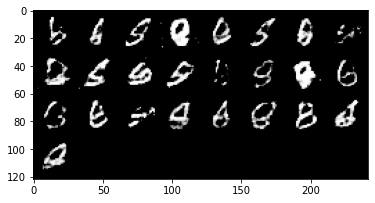

tensor([-0.0591,  0.0558, -0.3418, -0.0909,  0.2800,  0.5009, -0.2768, -0.5449,
        -0.2623,  0.3121], requires_grad=True)


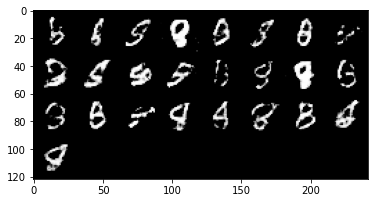

tensor([ 0.0651, -0.0498,  0.3479,  0.0970, -0.2861, -0.4951,  0.2829,  0.5391,
         0.2684, -0.3062], requires_grad=True)


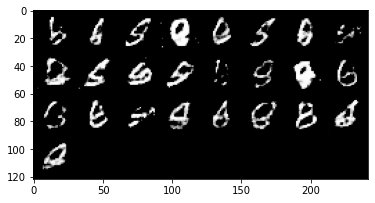

tensor([-0.0659,  0.0490, -0.3486, -0.0977,  0.2868,  0.4957, -0.2821, -0.5381,
        -0.2691,  0.3053], requires_grad=True)


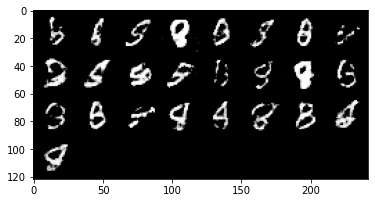

tensor([ 0.0781, -0.0612,  0.3390,  0.1102, -0.2768, -0.4871,  0.2957,  0.5298,
         0.2827, -0.3191], requires_grad=True)


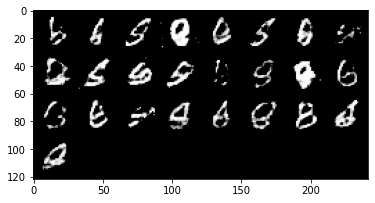

tensor([-0.0733,  0.0659, -0.3339, -0.1149,  0.2718,  0.4913, -0.3002, -0.5340,
        -0.2776,  0.3140], requires_grad=True)


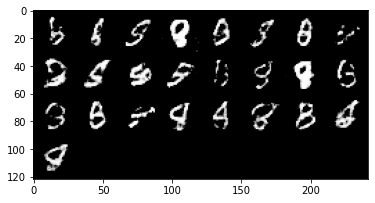

tensor([ 0.1024, -0.0952,  0.3549,  0.0798, -0.2947, -0.5074,  0.3222,  0.4858,
         0.3004, -0.2727], requires_grad=True)


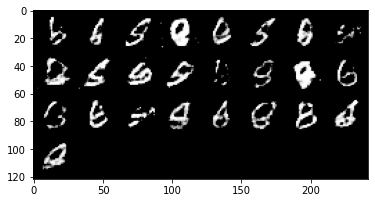

tensor([ 0.1224,  0.3759, -0.2013,  0.1514,  0.1242,  0.3969, -0.6670, -0.3693,
        -0.1314,  0.0960], requires_grad=True)


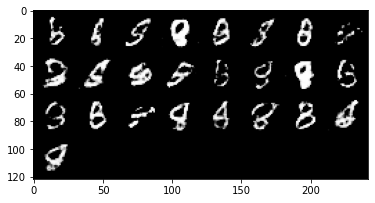

tensor([-0.1210, -0.3747,  0.2028, -0.1529, -0.1228, -0.3986,  0.6659,  0.3709,
         0.1301, -0.0947], requires_grad=True)


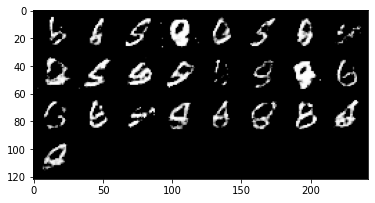

tensor([ 0.0888,  0.3489, -0.1727,  0.1922,  0.1614,  0.3734, -0.6477, -0.4159,
        -0.1688,  0.1325], requires_grad=True)


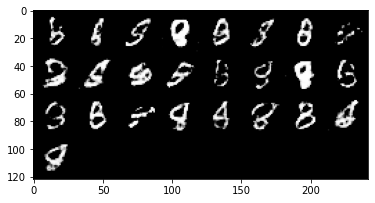

tensor([-0.1952, -0.2831,  0.0905, -0.1119, -0.0782, -0.3099,  0.6096,  0.5527,
         0.2827, -0.0466], requires_grad=True)


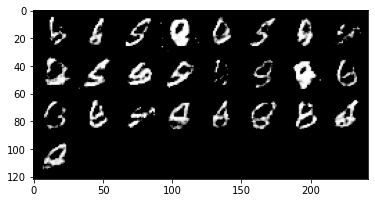

tensor([ 0.1891,  0.2889, -0.0845,  0.1177,  0.0722,  0.3037, -0.6151, -0.5462,
        -0.2884,  0.0525], requires_grad=True)


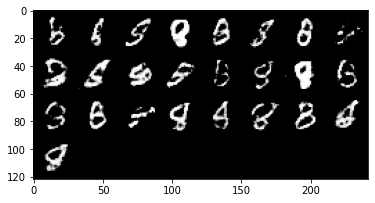

tensor([-0.2001, -0.2804,  0.0749, -0.1284, -0.0825, -0.2953,  0.6283,  0.5391,
         0.2799, -0.0428], requires_grad=True)


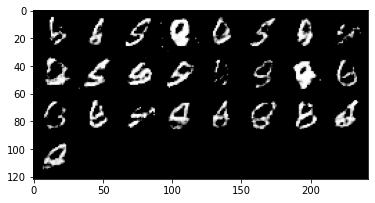

tensor([ 0.2012,  0.2815, -0.0761,  0.1271,  0.0837,  0.2964, -0.6268, -0.5400,
        -0.2786,  0.0416], requires_grad=True)


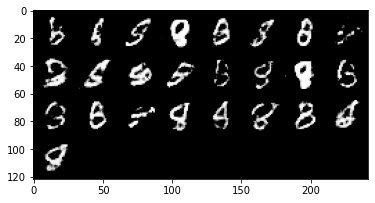

tensor([-0.1873, -0.2683,  0.0611, -0.1125, -0.0687, -0.2833,  0.6483,  0.5293,
         0.2969, -0.0577], requires_grad=True)


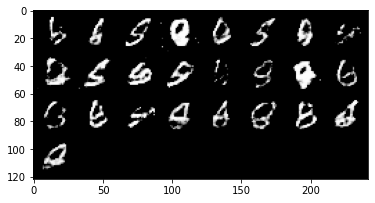

tensor([ 0.1833,  0.2727, -0.0653,  0.1168,  0.0646,  0.2794, -0.6530, -0.5255,
        -0.2930,  0.0619], requires_grad=True)


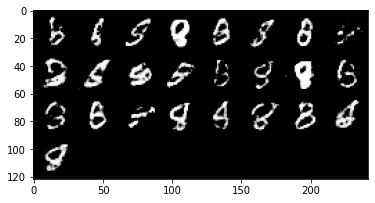

tensor([-0.1878, -0.2772,  0.0700, -0.1214, -0.0598, -0.2744,  0.6571,  0.5202,
         0.2879, -0.0666], requires_grad=True)


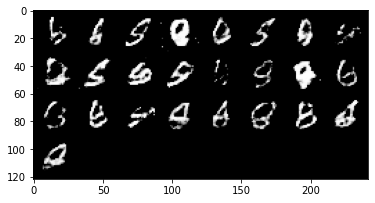

tensor([ 0.1129,  0.3142, -0.1239,  0.0519, -0.0047,  0.1924, -0.6632, -0.5375,
        -0.3241,  0.0015], requires_grad=True)


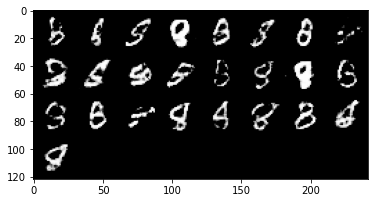

tensor([-0.1442, -0.3379,  0.1547, -0.0144,  0.0400, -0.2207,  0.6028,  0.5528,
         0.3474,  0.0340], requires_grad=True)


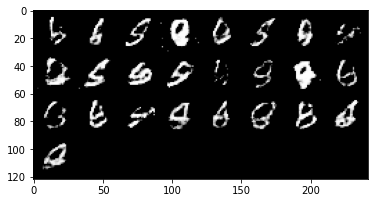

tensor([ 0.0552,  0.4746, -0.2733, -0.0874, -0.1472,  0.1393, -0.5590, -0.5042,
        -0.2785,  0.0659], requires_grad=True)


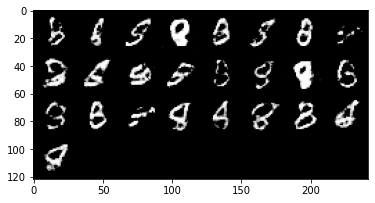

tensor([ 0.0263, -0.4261,  0.2090,  0.0085,  0.2446, -0.0644,  0.5172,  0.6296,
         0.2146,  0.0147], requires_grad=True)


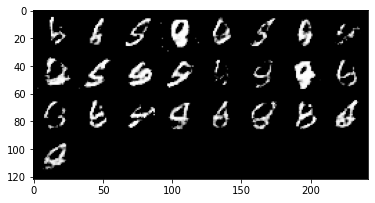

tensor([-0.0322,  0.4322, -0.2150, -0.0026, -0.2506,  0.0586, -0.5116, -0.6241,
        -0.2206, -0.0088], requires_grad=True)


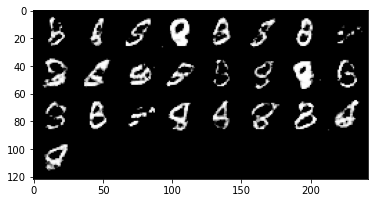

tensor([ 0.0262, -0.4250,  0.2084,  0.0085,  0.2439, -0.0643,  0.5159,  0.6280,
         0.2259,  0.0147], requires_grad=True)


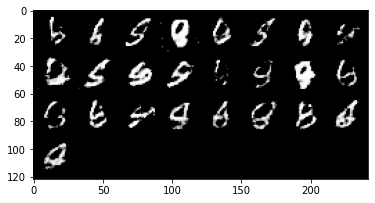

tensor([ 0.0878,  0.3568, -0.3493,  0.1074, -0.3889, -0.0453, -0.4582, -0.5832,
        -0.1349,  0.1005], requires_grad=True)


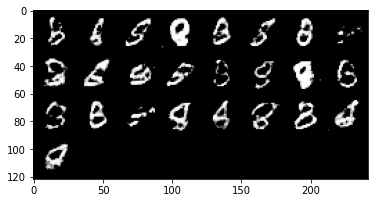

tensor([-0.0803, -0.3660,  0.3428, -0.1001,  0.3826,  0.0377,  0.4522,  0.5932,
         0.1276, -0.1087], requires_grad=True)


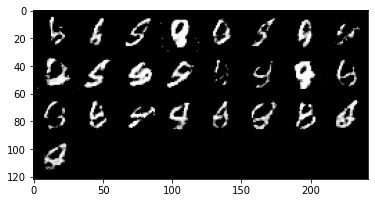

tensor([ 0.0509,  0.3428, -0.3815,  0.0711, -0.4221, -0.0696, -0.4310, -0.5751,
        -0.0993,  0.1422], requires_grad=True)


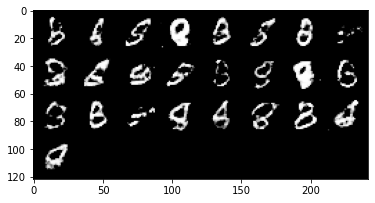

tensor([-0.0529, -0.3405,  0.3832, -0.0730,  0.4237,  0.0676,  0.4326,  0.5726,
         0.0972, -0.1441], requires_grad=True)


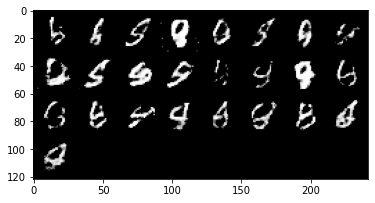

tensor([ 0.0571,  0.3453, -0.3797,  0.0773, -0.4204, -0.0718, -0.4375, -0.5695,
        -0.1015,  0.1402], requires_grad=True)


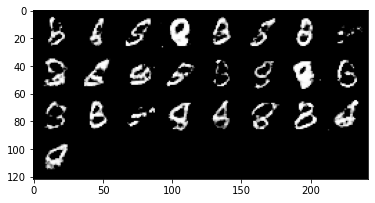

tensor([-0.0595, -0.3426,  0.3819, -0.0748,  0.4177,  0.0693,  0.4396,  0.5715,
         0.0990, -0.1377], requires_grad=True)


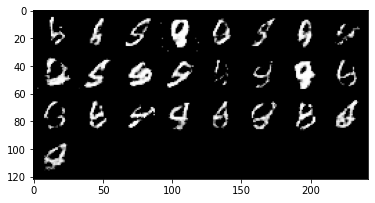

tensor([ 0.0472,  0.3323, -0.3973,  0.0626, -0.4079, -0.0825, -0.4554, -0.5628,
        -0.1124,  0.1259], requires_grad=True)


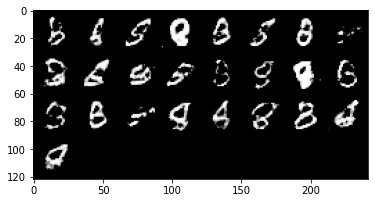

tensor([-0.0402, -0.3379,  0.4026, -0.0692,  0.3995,  0.0891,  0.4469,  0.5675,
         0.1188, -0.1186], requires_grad=True)


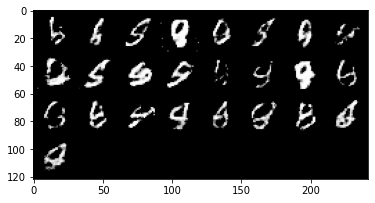

tensor([ 0.0453,  0.3422, -0.4068,  0.0742, -0.3933, -0.0836, -0.4405, -0.5712,
        -0.1237,  0.1131], requires_grad=True)


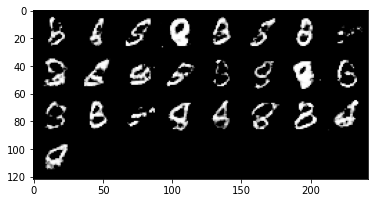

tensor([-0.0582, -0.3572,  0.4222, -0.0622,  0.3834,  0.0968,  0.4310,  0.5626,
         0.1120, -0.1265], requires_grad=True)


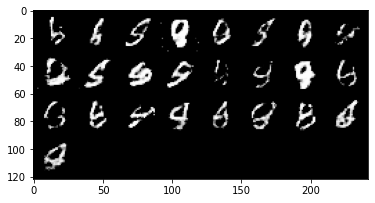

tensor([ 0.3920,  0.2343, -0.2000,  0.3899, -0.2204, -0.3716, -0.1953, -0.1259,
         0.4818,  0.3560], requires_grad=True)


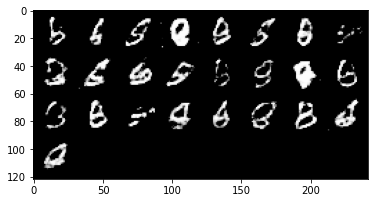

tensor([-0.3655, -0.2034,  0.2429, -0.3633,  0.2639,  0.3445,  0.1634,  0.1667,
        -0.5324, -0.3284], requires_grad=True)


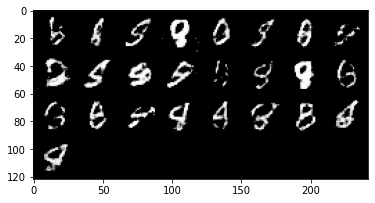

In [ ]:
# latent_points = generate_latent_points(100, 25)
zeroes = torch.full((25,), 1)
for i in range(100):
    with torch.no_grad():
        netCG.label_emb.weight[1] = torch.from_numpy(walk_r[i])
        print(netCG.label_emb.weight[1])
        generated = netCG(latent_points, zeroes)
        show(generated)

## Random walk

In [ ]:
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
embedding_weights = netCG.label_emb.weight.detach().numpy()

In [ ]:
import numpy as np

class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        
        self.x0 = x0
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        curr_point = self.x0

        walk = []

        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.full((n_step, 10), self.x0)

        print(w.shape)
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1], (10,))
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w

In [ ]:
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth', map_location=torch.device('cpu')))
brownian = Brownian(netCG.label_emb.weight[1].detach().numpy())

In [ ]:
walk = brownian.gen_random_walk()

(100, 10)


tensor([ 1.3597, -0.8621, -1.1897,  0.8339,  1.0711, -1.4130,  1.0173,  2.3083,
        -1.6028, -1.6679], requires_grad=True)


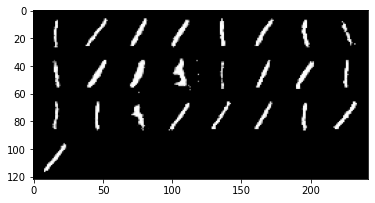

tensor([ 1.4597, -0.7621, -1.2897,  0.7339,  0.9711, -1.3130,  0.9173,  2.2083,
        -1.7028, -1.5679], requires_grad=True)


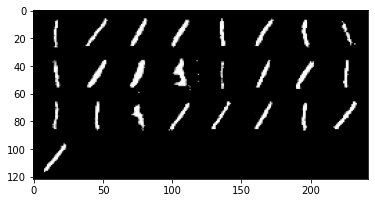

tensor([ 1.3597, -0.8621, -1.3897,  0.8339,  0.8711, -1.4130,  1.0173,  2.3083,
        -1.8028, -1.6679], requires_grad=True)


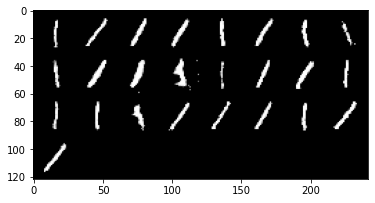

tensor([ 1.4597, -0.9621, -1.4897,  0.7339,  0.9711, -1.5130,  0.9173,  2.2083,
        -1.7028, -1.7679], requires_grad=True)


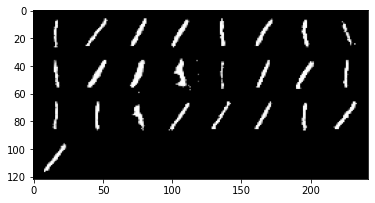

tensor([ 1.5597, -0.8621, -1.3897,  0.6339,  1.0711, -1.6130,  1.0173,  2.3083,
        -1.8028, -1.8679], requires_grad=True)


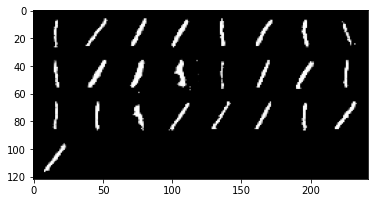

tensor([ 1.4597, -0.7621, -1.2897,  0.5339,  0.9711, -1.7130,  1.1173,  2.4083,
        -1.7028, -1.9679], requires_grad=True)


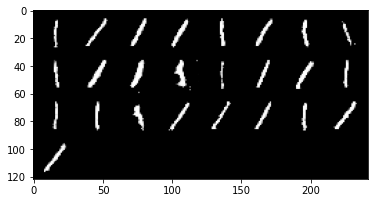

tensor([ 1.3597, -0.6621, -1.1897,  0.6339,  1.0711, -1.8130,  1.2173,  2.3083,
        -1.8028, -2.0679], requires_grad=True)


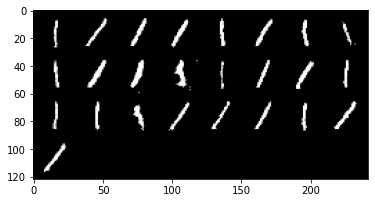

tensor([ 1.4597, -0.7621, -1.0897,  0.5339,  1.1711, -1.7130,  1.3173,  2.2083,
        -1.9028, -1.9679], requires_grad=True)


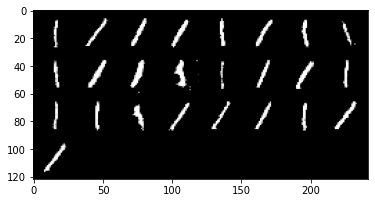

tensor([ 1.5597, -0.6621, -1.1897,  0.4339,  1.2711, -1.8130,  1.2173,  2.1083,
        -2.0028, -2.0679], requires_grad=True)


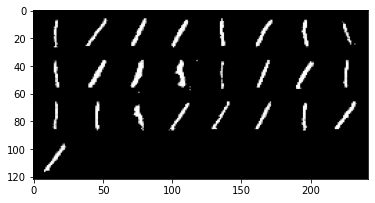

tensor([ 1.4597, -0.7621, -1.0897,  0.5339,  1.1711, -1.9130,  1.3173,  2.0083,
        -1.9028, -1.9679], requires_grad=True)


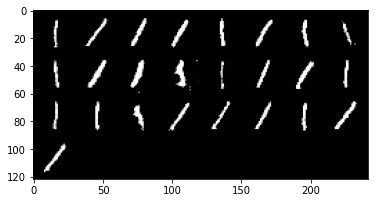

tensor([ 1.5597, -0.6621, -1.1897,  0.4339,  1.0711, -2.0130,  1.2173,  2.1083,
        -2.0028, -1.8679], requires_grad=True)


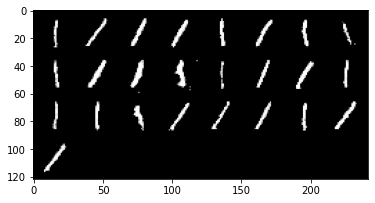

tensor([ 1.4597, -0.5621, -1.2897,  0.3339,  1.1711, -1.9130,  1.1173,  2.0083,
        -2.1028, -1.7679], requires_grad=True)


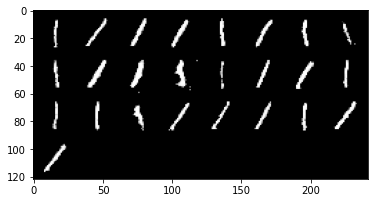

tensor([ 1.3597, -0.4621, -1.3897,  0.4339,  1.2711, -2.0130,  1.0173,  2.1083,
        -2.0028, -1.8679], requires_grad=True)


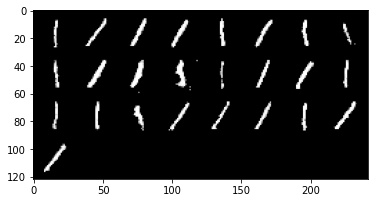

tensor([ 1.2597, -0.3621, -1.4897,  0.5339,  1.1711, -2.1130,  0.9173,  2.2083,
        -1.9028, -1.7679], requires_grad=True)


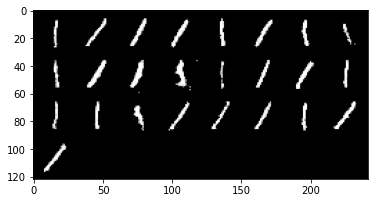

tensor([ 1.1597, -0.2621, -1.5897,  0.4339,  1.0711, -2.2130,  1.0173,  2.3083,
        -1.8028, -1.8679], requires_grad=True)


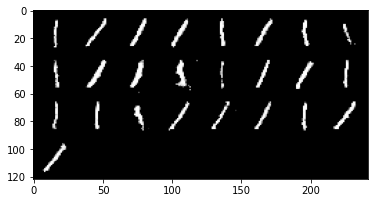

tensor([ 1.2597, -0.3621, -1.6897,  0.3339,  1.1711, -2.1130,  0.9173,  2.4083,
        -1.9028, -1.9679], requires_grad=True)


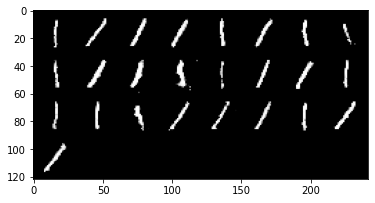

tensor([ 1.3597, -0.2621, -1.7897,  0.2339,  1.2711, -2.2130,  0.8173,  2.5083,
        -2.0028, -2.0679], requires_grad=True)


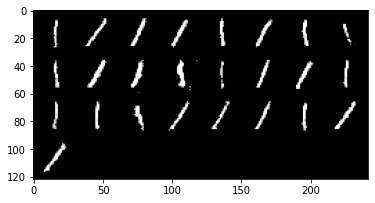

tensor([ 1.2597, -0.3621, -1.6897,  0.3339,  1.1711, -2.1130,  0.9173,  2.4083,
        -1.9028, -2.1679], requires_grad=True)


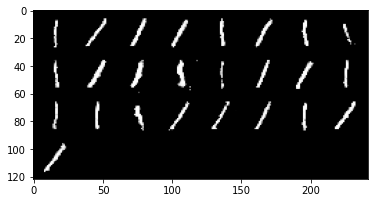

tensor([ 1.1597, -0.4621, -1.5897,  0.2339,  1.2711, -2.2130,  0.8173,  2.3083,
        -2.0028, -2.0679], requires_grad=True)


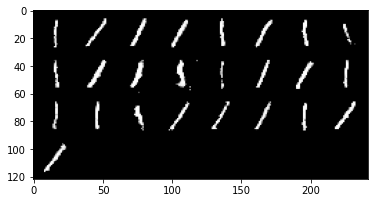

tensor([ 1.0597, -0.3621, -1.6897,  0.3339,  1.3711, -2.1130,  0.9173,  2.2083,
        -1.9028, -1.9679], requires_grad=True)


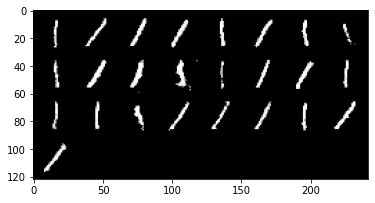

tensor([ 1.1597, -0.2621, -1.5897,  0.2339,  1.4711, -2.2130,  1.0173,  2.3083,
        -1.8028, -2.0679], requires_grad=True)


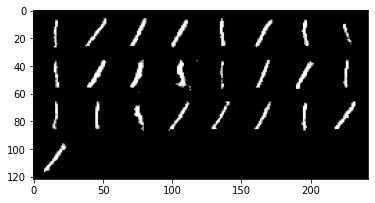

tensor([ 1.2597, -0.3621, -1.4897,  0.1339,  1.5711, -2.3130,  0.9173,  2.4083,
        -1.9028, -1.9679], requires_grad=True)


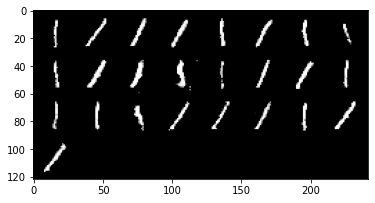

tensor([ 1.3597, -0.4621, -1.5897,  0.0339,  1.4711, -2.4130,  1.0173,  2.3083,
        -1.8028, -2.0679], requires_grad=True)


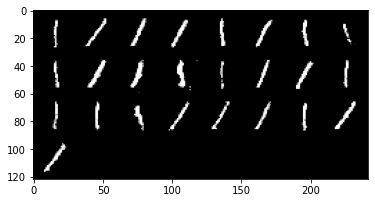

tensor([ 1.4597, -0.3621, -1.6897,  0.1339,  1.5711, -2.5130,  1.1173,  2.4083,
        -1.9028, -1.9679], requires_grad=True)


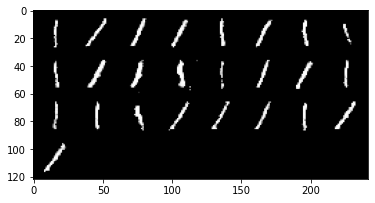

tensor([ 1.5597, -0.4621, -1.7897,  0.2339,  1.4711, -2.6130,  1.0173,  2.3083,
        -1.8028, -1.8679], requires_grad=True)


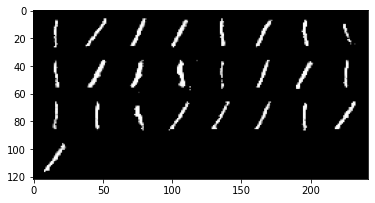

tensor([ 1.4597, -0.3621, -1.6897,  0.1339,  1.3711, -2.7130,  1.1173,  2.2083,
        -1.7028, -1.9679], requires_grad=True)


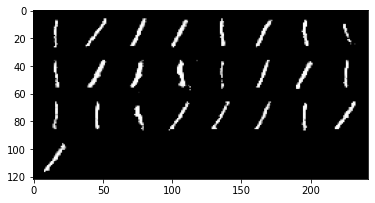

tensor([ 1.3597, -0.2621, -1.7897,  0.0339,  1.2711, -2.6130,  1.0173,  2.1083,
        -1.6028, -2.0679], requires_grad=True)


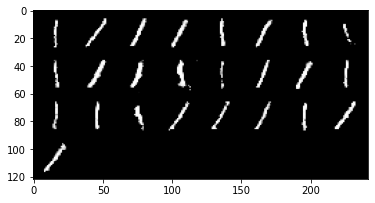

tensor([ 1.4597, -0.3621, -1.8897, -0.0661,  1.1711, -2.5130,  0.9173,  2.2083,
        -1.5028, -1.9679], requires_grad=True)


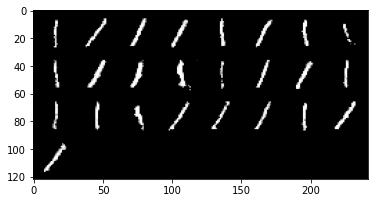

tensor([ 1.5597, -0.4621, -1.7897,  0.0339,  1.2711, -2.6130,  0.8173,  2.3083,
        -1.6028, -1.8679], requires_grad=True)


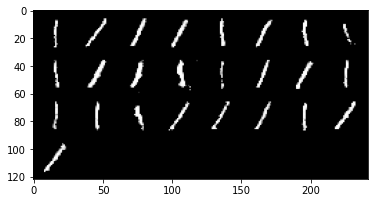

tensor([ 1.6597, -0.3621, -1.8897, -0.0661,  1.3711, -2.5130,  0.7173,  2.4083,
        -1.7028, -1.9679], requires_grad=True)


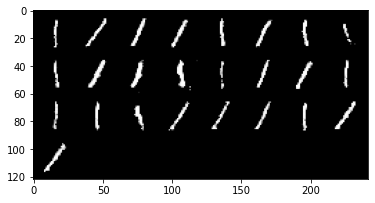

tensor([ 1.5597, -0.2621, -1.9897, -0.1661,  1.4711, -2.4130,  0.6173,  2.3083,
        -1.8028, -1.8679], requires_grad=True)


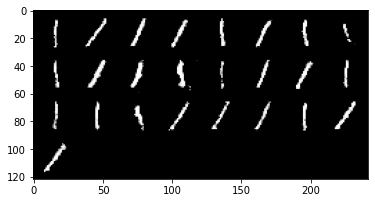

tensor([ 1.6597, -0.1621, -1.8897, -0.2661,  1.5711, -2.5130,  0.5173,  2.4083,
        -1.9028, -1.9679], requires_grad=True)


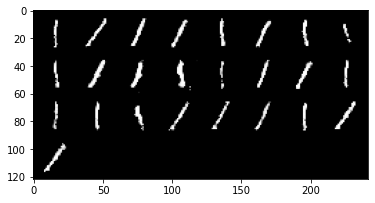

tensor([ 1.5597, -0.2621, -1.9897, -0.3661,  1.4711, -2.4130,  0.6173,  2.3083,
        -1.8028, -1.8679], requires_grad=True)


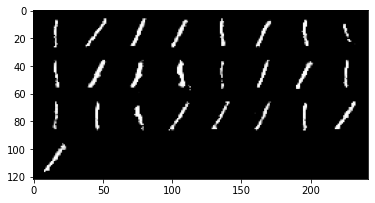

tensor([ 1.6597, -0.3621, -2.0897, -0.2661,  1.3711, -2.3130,  0.5173,  2.2083,
        -1.7028, -1.9679], requires_grad=True)


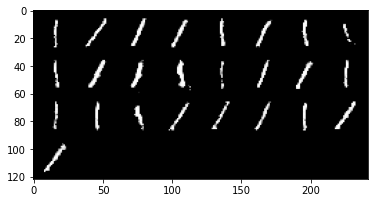

tensor([ 1.7597, -0.2621, -2.1897, -0.3661,  1.4711, -2.4130,  0.6173,  2.1083,
        -1.8028, -1.8679], requires_grad=True)


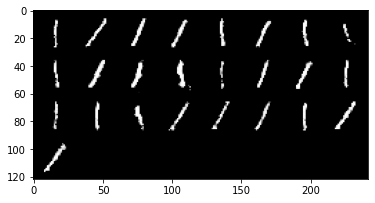

tensor([ 1.8597, -0.3621, -2.2897, -0.4661,  1.5711, -2.5130,  0.5173,  2.2083,
        -1.9028, -1.7679], requires_grad=True)


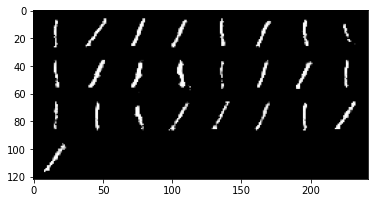

tensor([ 1.9597, -0.4621, -2.1897, -0.5661,  1.6711, -2.4130,  0.4173,  2.1083,
        -2.0028, -1.6679], requires_grad=True)


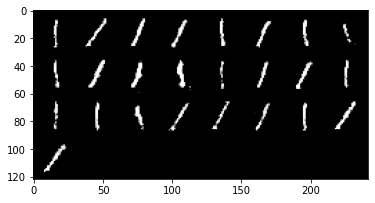

tensor([ 1.8597, -0.5621, -2.0897, -0.6661,  1.5711, -2.5130,  0.5173,  2.2083,
        -2.1028, -1.5679], requires_grad=True)


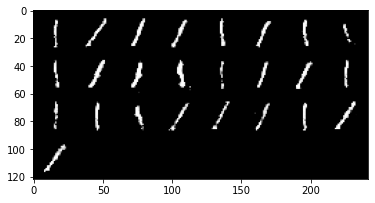

tensor([ 1.9597, -0.6621, -2.1897, -0.7661,  1.6711, -2.6130,  0.6173,  2.3083,
        -2.0028, -1.4679], requires_grad=True)


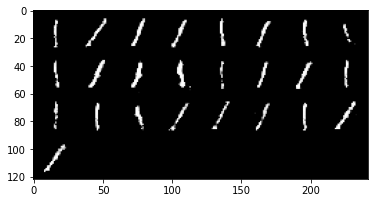

tensor([ 1.8597, -0.5621, -2.0897, -0.6661,  1.5711, -2.5130,  0.5173,  2.4083,
        -1.9028, -1.3679], requires_grad=True)


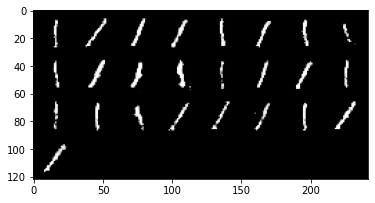

tensor([ 1.9597, -0.4621, -1.9897, -0.7661,  1.4711, -2.6130,  0.4173,  2.5083,
        -1.8028, -1.2679], requires_grad=True)


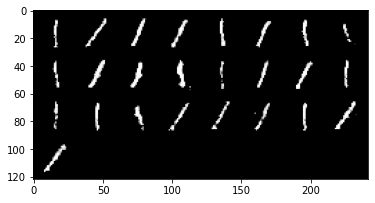

tensor([ 2.0597, -0.3621, -2.0897, -0.6661,  1.3711, -2.5130,  0.5173,  2.4083,
        -1.9028, -1.1679], requires_grad=True)


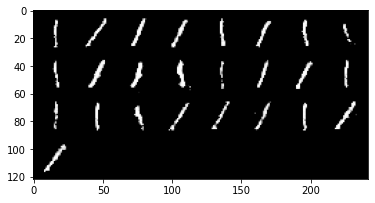

tensor([ 2.1597, -0.2621, -2.1897, -0.5661,  1.4711, -2.4130,  0.6173,  2.5083,
        -2.0028, -1.2679], requires_grad=True)


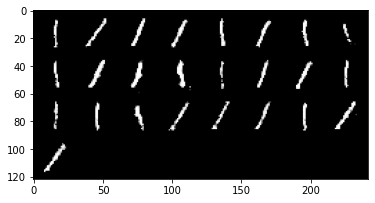

tensor([ 2.0597, -0.1621, -2.2897, -0.4661,  1.5711, -2.5130,  0.7173,  2.6083,
        -1.9028, -1.3679], requires_grad=True)


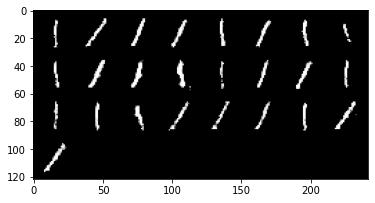

tensor([ 2.1597, -0.2621, -2.3897, -0.5661,  1.6711, -2.4130,  0.8173,  2.7083,
        -1.8028, -1.4679], requires_grad=True)


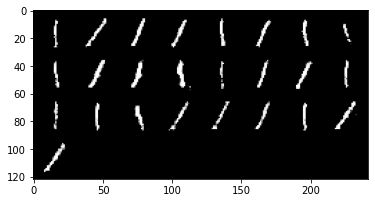

tensor([ 2.0597, -0.3621, -2.2897, -0.4661,  1.5711, -2.5130,  0.9173,  2.6083,
        -1.7028, -1.5679], requires_grad=True)


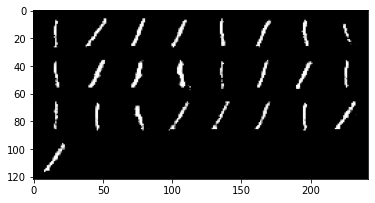

tensor([ 2.1597, -0.2621, -2.3897, -0.5661,  1.4711, -2.6130,  0.8173,  2.7083,
        -1.8028, -1.6679], requires_grad=True)


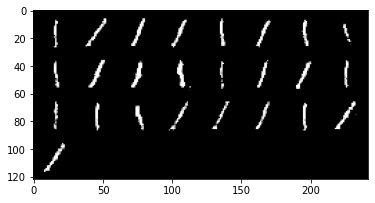

tensor([ 2.2597, -0.1621, -2.4897, -0.4661,  1.5711, -2.7130,  0.9173,  2.6083,
        -1.7028, -1.5679], requires_grad=True)


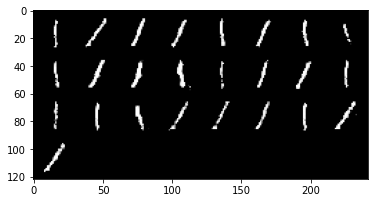

tensor([ 2.1597, -0.2621, -2.5897, -0.5661,  1.4711, -2.6130,  1.0173,  2.5083,
        -1.8028, -1.4679], requires_grad=True)


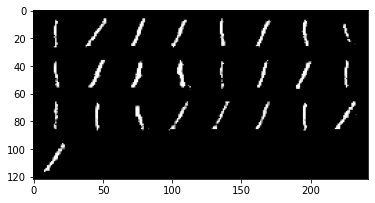

tensor([ 2.2597, -0.3621, -2.4897, -0.4661,  1.5711, -2.5130,  0.9173,  2.4083,
        -1.7028, -1.5679], requires_grad=True)


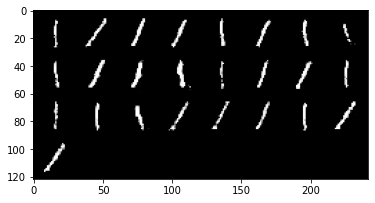

tensor([ 2.1597, -0.4621, -2.5897, -0.3661,  1.6711, -2.4130,  1.0173,  2.5083,
        -1.8028, -1.6679], requires_grad=True)


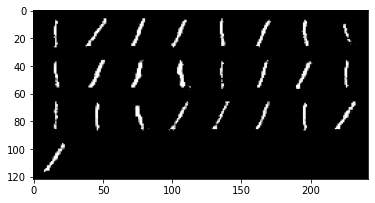

tensor([ 2.0597, -0.5621, -2.6897, -0.4661,  1.5711, -2.5130,  0.9173,  2.6083,
        -1.7028, -1.7679], requires_grad=True)


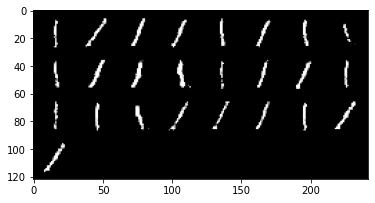

tensor([ 2.1597, -0.4621, -2.5897, -0.5661,  1.6711, -2.6130,  1.0173,  2.7083,
        -1.6028, -1.6679], requires_grad=True)


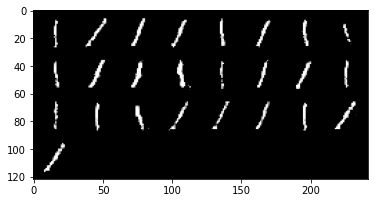

tensor([ 2.2597, -0.5621, -2.6897, -0.6661,  1.7711, -2.5130,  1.1173,  2.8083,
        -1.7028, -1.7679], requires_grad=True)


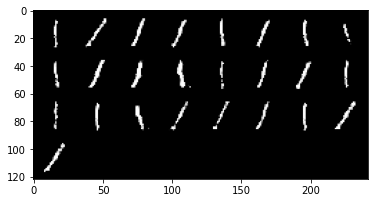

tensor([ 2.3597, -0.6621, -2.5897, -0.5661,  1.8711, -2.6130,  1.0173,  2.9083,
        -1.6028, -1.8679], requires_grad=True)


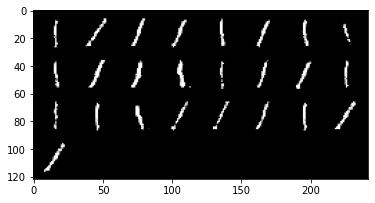

tensor([ 2.2597, -0.5621, -2.4897, -0.6661,  1.7711, -2.5130,  0.9173,  2.8083,
        -1.7028, -1.7679], requires_grad=True)


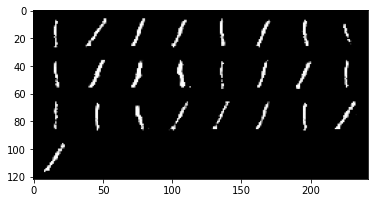

tensor([ 2.1597, -0.4621, -2.3897, -0.7661,  1.8711, -2.4130,  1.0173,  2.9083,
        -1.8028, -1.6679], requires_grad=True)


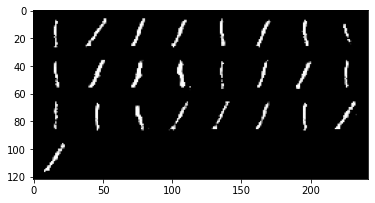

tensor([ 2.0597, -0.3621, -2.2897, -0.8661,  1.7711, -2.3130,  0.9173,  2.8083,
        -1.7028, -1.5679], requires_grad=True)


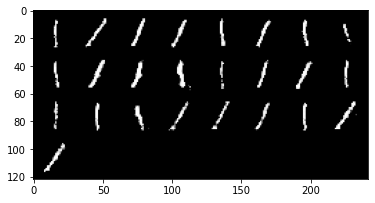

tensor([ 2.1597, -0.2621, -2.1897, -0.7661,  1.8711, -2.2130,  1.0173,  2.9083,
        -1.6028, -1.6679], requires_grad=True)


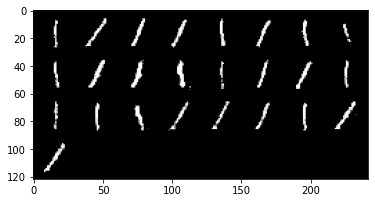

tensor([ 2.2597, -0.1621, -2.2897, -0.6661,  1.9711, -2.1130,  1.1173,  3.0083,
        -1.7028, -1.7679], requires_grad=True)


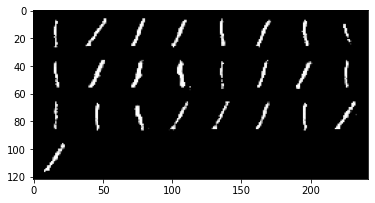

tensor([ 2.3597, -0.2621, -2.3897, -0.7661,  2.0711, -2.0130,  1.0173,  2.9083,
        -1.6028, -1.8679], requires_grad=True)


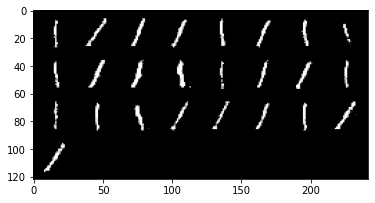

tensor([ 2.4597, -0.1621, -2.2897, -0.8661,  2.1711, -2.1130,  0.9173,  3.0083,
        -1.5028, -1.9679], requires_grad=True)


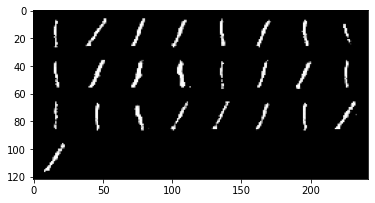

tensor([ 2.5597, -0.0621, -2.1897, -0.7661,  2.2711, -2.0130,  1.0173,  2.9083,
        -1.6028, -1.8679], requires_grad=True)


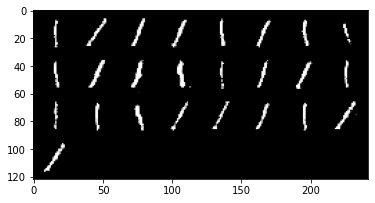

tensor([ 2.4597,  0.0379, -2.2897, -0.8661,  2.1711, -1.9130,  0.9173,  2.8083,
        -1.7028, -1.9679], requires_grad=True)


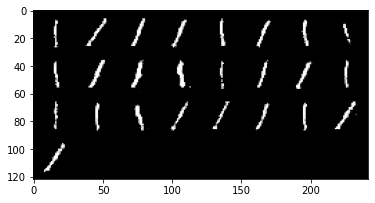

tensor([ 2.3597, -0.0621, -2.1897, -0.7661,  2.2711, -2.0130,  1.0173,  2.9083,
        -1.8028, -1.8679], requires_grad=True)


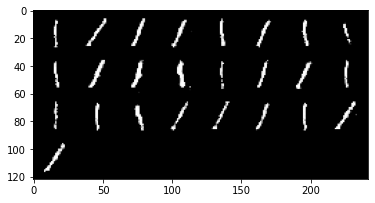

tensor([ 2.4597, -0.1621, -2.2897, -0.6661,  2.1711, -2.1130,  0.9173,  2.8083,
        -1.7028, -1.7679], requires_grad=True)


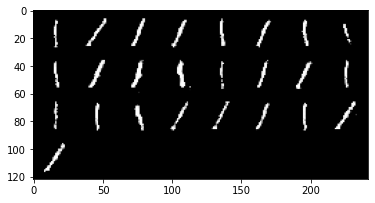

tensor([ 2.5597, -0.2621, -2.3897, -0.7661,  2.2711, -2.2130,  1.0173,  2.9083,
        -1.6028, -1.8679], requires_grad=True)


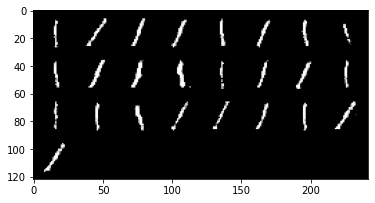

tensor([ 2.4597, -0.3621, -2.4897, -0.6661,  2.1711, -2.1130,  1.1173,  2.8083,
        -1.7028, -1.9679], requires_grad=True)


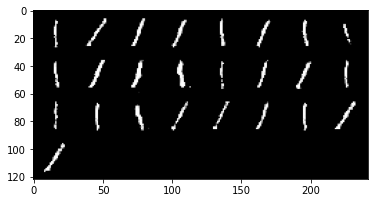

tensor([ 2.3597, -0.4621, -2.5897, -0.5661,  2.2711, -2.0130,  1.0173,  2.9083,
        -1.8028, -2.0679], requires_grad=True)


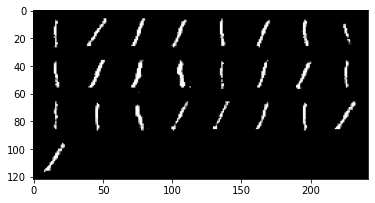

tensor([ 2.4597, -0.5621, -2.4897, -0.4661,  2.1711, -2.1130,  0.9173,  2.8083,
        -1.9028, -1.9679], requires_grad=True)


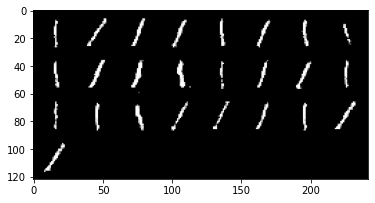

tensor([ 2.3597, -0.4621, -2.5897, -0.3661,  2.2711, -2.2130,  1.0173,  2.7083,
        -1.8028, -1.8679], requires_grad=True)


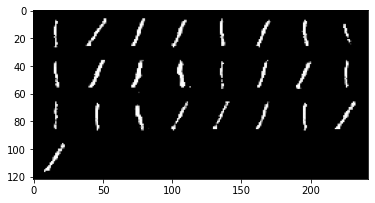

tensor([ 2.4597, -0.5621, -2.4897, -0.2661,  2.3711, -2.3130,  1.1173,  2.8083,
        -1.7028, -1.9679], requires_grad=True)


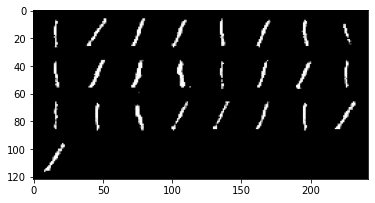

tensor([ 2.5597, -0.6621, -2.5897, -0.3661,  2.4711, -2.2130,  1.0173,  2.9083,
        -1.8028, -1.8679], requires_grad=True)


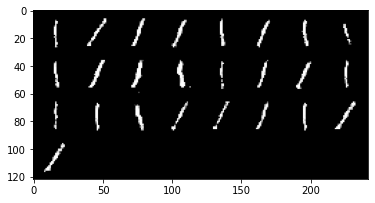

tensor([ 2.6597, -0.7621, -2.6897, -0.4661,  2.3711, -2.1130,  1.1173,  2.8083,
        -1.9028, -1.7679], requires_grad=True)


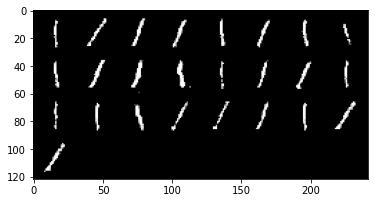

tensor([ 2.7597, -0.6621, -2.5897, -0.5661,  2.2711, -2.2130,  1.2173,  2.9083,
        -1.8028, -1.8679], requires_grad=True)


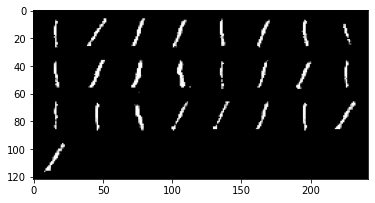

tensor([ 2.8597, -0.7621, -2.6897, -0.6661,  2.3711, -2.3130,  1.3173,  2.8083,
        -1.7028, -1.7679], requires_grad=True)


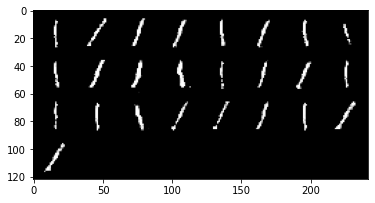

tensor([ 2.9597, -0.8621, -2.5897, -0.7661,  2.2711, -2.4130,  1.2173,  2.7083,
        -1.8028, -1.6679], requires_grad=True)


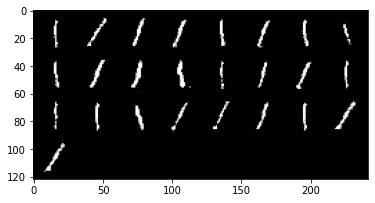

tensor([ 2.8597, -0.7621, -2.6897, -0.6661,  2.3711, -2.3130,  1.3173,  2.8083,
        -1.7028, -1.5679], requires_grad=True)


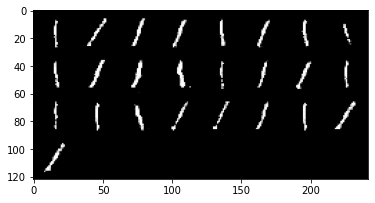

tensor([ 2.9597, -0.8621, -2.7897, -0.7661,  2.2711, -2.4130,  1.2173,  2.9083,
        -1.6028, -1.6679], requires_grad=True)


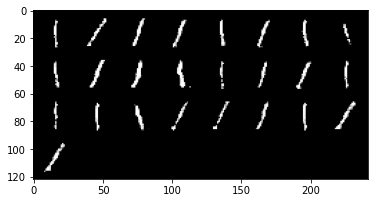

tensor([ 2.8597, -0.7621, -2.6897, -0.6661,  2.3711, -2.5130,  1.1173,  2.8083,
        -1.7028, -1.5679], requires_grad=True)


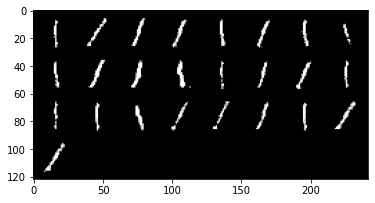

tensor([ 2.7597, -0.8621, -2.7897, -0.5661,  2.2711, -2.6130,  1.0173,  2.7083,
        -1.6028, -1.4679], requires_grad=True)


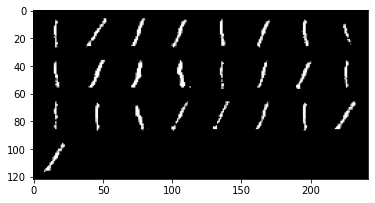

tensor([ 2.8597, -0.9621, -2.6897, -0.6661,  2.1711, -2.7130,  1.1173,  2.8083,
        -1.7028, -1.3679], requires_grad=True)


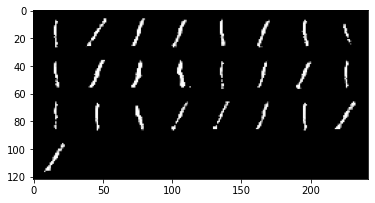

tensor([ 2.7597, -0.8621, -2.5897, -0.5661,  2.2711, -2.8130,  1.0173,  2.9083,
        -1.8028, -1.4679], requires_grad=True)


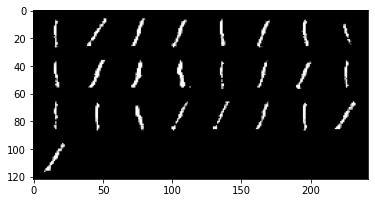

tensor([ 2.6597, -0.7621, -2.4897, -0.6661,  2.1711, -2.9130,  1.1173,  3.0083,
        -1.7028, -1.3679], requires_grad=True)


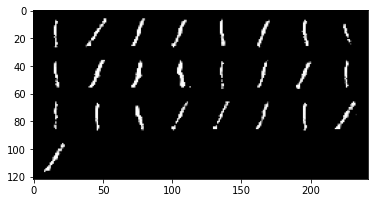

tensor([ 2.7597, -0.6621, -2.3897, -0.7661,  2.0711, -2.8130,  1.2173,  3.1083,
        -1.8028, -1.2679], requires_grad=True)


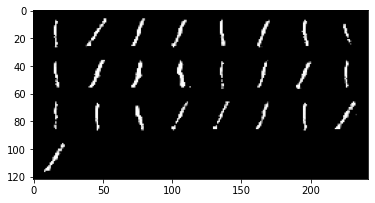

tensor([ 2.6597, -0.7621, -2.2897, -0.8661,  2.1711, -2.9130,  1.1173,  3.2083,
        -1.7028, -1.3679], requires_grad=True)


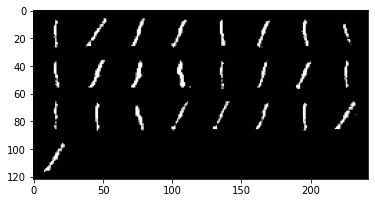

tensor([ 2.7597, -0.6621, -2.1897, -0.7661,  2.2711, -2.8130,  1.0173,  3.1083,
        -1.8028, -1.2679], requires_grad=True)


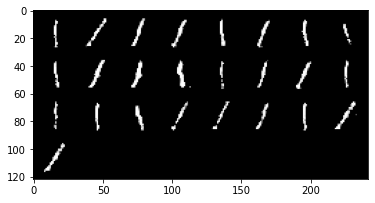

tensor([ 2.6597, -0.5621, -2.2897, -0.8661,  2.3711, -2.7130,  1.1173,  3.0083,
        -1.9028, -1.3679], requires_grad=True)


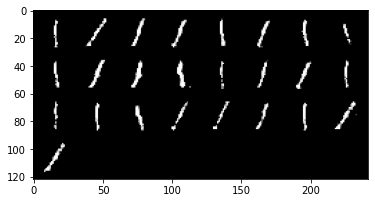

tensor([ 2.5597, -0.6621, -2.1897, -0.7661,  2.2711, -2.8130,  1.0173,  3.1083,
        -1.8028, -1.2679], requires_grad=True)


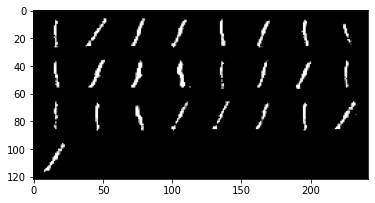

tensor([ 2.4597, -0.7621, -2.2897, -0.6661,  2.1711, -2.9130,  1.1173,  3.0083,
        -1.7028, -1.1679], requires_grad=True)


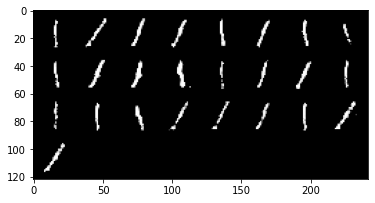

tensor([ 2.5597, -0.8621, -2.1897, -0.5661,  2.0711, -3.0130,  1.0173,  3.1083,
        -1.6028, -1.2679], requires_grad=True)


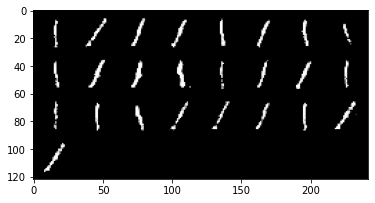

tensor([ 2.4597, -0.7621, -2.2897, -0.6661,  2.1711, -3.1130,  0.9173,  3.2083,
        -1.5028, -1.1679], requires_grad=True)


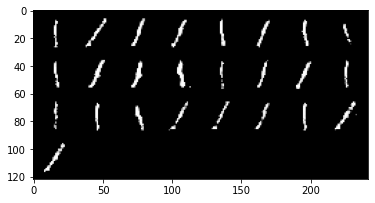

tensor([ 2.5597, -0.6621, -2.1897, -0.5661,  2.2711, -3.2130,  1.0173,  3.1083,
        -1.6028, -1.2679], requires_grad=True)


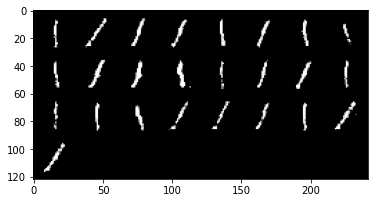

tensor([ 2.4597, -0.7621, -2.0897, -0.6661,  2.3711, -3.1130,  0.9173,  3.2083,
        -1.5028, -1.3679], requires_grad=True)


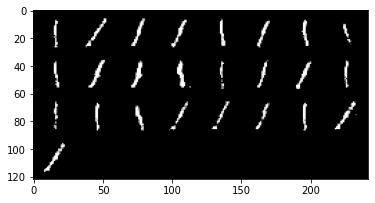

tensor([ 2.5597, -0.6621, -1.9897, -0.5661,  2.2711, -3.0130,  1.0173,  3.1083,
        -1.4028, -1.2679], requires_grad=True)


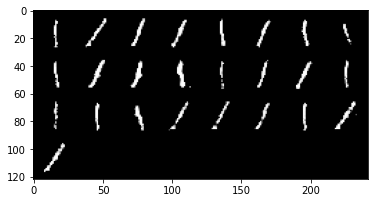

tensor([ 2.6597, -0.5621, -1.8897, -0.6661,  2.1711, -2.9130,  0.9173,  3.2083,
        -1.5028, -1.3679], requires_grad=True)


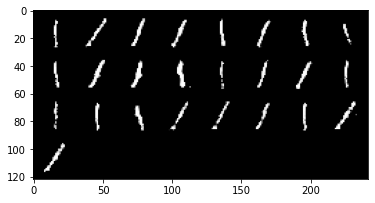

tensor([ 2.5597, -0.4621, -1.9897, -0.7661,  2.2711, -3.0130,  0.8173,  3.1083,
        -1.6028, -1.4679], requires_grad=True)


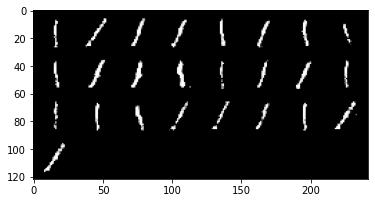

tensor([ 2.6597, -0.3621, -1.8897, -0.8661,  2.3711, -2.9130,  0.9173,  3.2083,
        -1.5028, -1.3679], requires_grad=True)


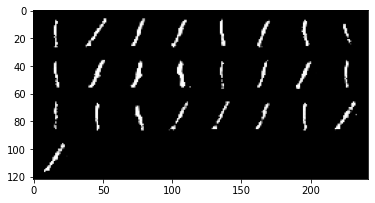

tensor([ 2.5597, -0.2621, -1.9897, -0.7661,  2.4711, -2.8130,  1.0173,  3.1083,
        -1.4028, -1.4679], requires_grad=True)


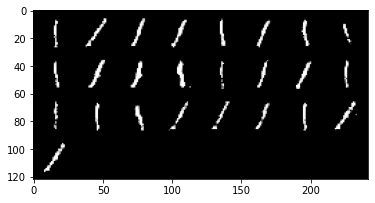

tensor([ 2.6597, -0.1621, -1.8897, -0.8661,  2.3711, -2.9130,  1.1173,  3.0083,
        -1.5028, -1.3679], requires_grad=True)

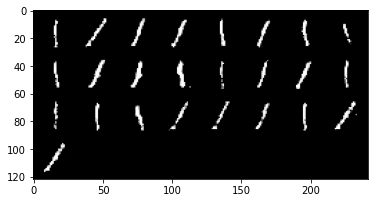

In [ ]:
zeroes = torch.full((25,), 1)
for i in range(100):
    with torch.no_grad():
        netCG.label_emb.weight[1] = torch.from_numpy(walk[i])
        print(netCG.label_emb.weight[1])
        generated = netCG(latent_points, zeroes)
        show(generated)